In [15]:
import pandas as pd
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
import onekey_algo.custom.components as okcomp
from onekey_algo import get_param_in_cwd

plt.rcParams['figure.dpi'] = 300
# model_names = ['Clinical', 'DL Radiomics', 'Non Guidance', 'Guidance', 'Nomogram']
model_names = ['Gleason', 'Radiomics', 'Habitat', 'Combined']
# 获取配置
task = get_param_in_cwd('task_column')[0]
bst_model = get_param_in_cwd('sel_model') or 'LR'
labelf = get_param_in_cwd('label_file') or os.path.join(mydir, 'label.csv')
group_info = get_param_in_cwd('dataset_column') or 'group'

# 读取label文件。
labels = [task]
label_data_ = pd.read_csv(labelf)
label_data_['ID'] = label_data_['ID'].map(lambda x: f"{x}.nii.gz" if not (f"{x}".endswith('.nii.gz') or  f"{x}".endswith('.nii')) else x)
label_data_ = label_data_[['ID', group_info] +  labels]
label_data_ = label_data_.dropna(axis=0)

ids = label_data_['ID']
print(label_data_.columns)
label_data = label_data_[['ID'] + labels]
label_data

Index(['ID', 'group', 'label'], dtype='object')


,ID,label
0,302.nii.gz,0
1,194.nii.gz,0
2,333.nii.gz,0
3,072.nii.gz,0
4,288.nii.gz,1
...,...,...
395,312.nii.gz,1
396,242.nii.gz,0
397,098.nii.gz,1
398,420.nii.gz,1


# 训练集-Nomogram

In [16]:
import pandas as pd
from onekey_algo.custom.components.comp1 import normalize_df, merge_results

subset = 'train'
sel_m = {'Clinical': 'LR', 'Radiomics': 'ExtraTrees', 'Habitat': 'RandomForest'}
# Clinical_results = pd.merge(pd.read_csv(f'./results/Clinic_{sel_m["Clinical"]}_{subset}.csv', header=0), label_data, on='ID', how='inner')
Rad_results = pd.merge(pd.read_csv(f'./results/Rad_{sel_m["Radiomics"]}_{subset}.csv', header=0), label_data, on='ID', how='inner')
Habitat_results = pd.merge(pd.read_csv(f'./results/Habitat_{sel_m["Habitat"]}_{subset}.csv', header=0), label_data, on='ID', how='inner')

ALL_results = merge_results(Rad_results, Habitat_results,
                            model_names=model_names[1:-1], label_col=task)
# ALL_results = normalize_df(ALL_results, not_norm=['ID'], method='minmax')
Clinic = pd.read_csv('clinic_sel.csv')
cnames = list(Clinic.columns[1:-2])
Clinic = Clinic[[c for c in Clinic.columns if c not in ['label', 'group']]]
ALL_results = pd.merge(ALL_results, Clinic, on='ID', how='inner')
ALL_results = ALL_results.dropna(axis=1)
ALL_results

,ID,label-0-0,Radiomics,label,label-0-1,Habitat,label-1,Gleason
0,001.nii.gz,0.494,0.506,1,0.118,0.882,1,9
1,003.nii.gz,0.507,0.493,0,0.620,0.380,0,7
2,005.nii.gz,0.633,0.367,1,0.134,0.866,1,8
3,013.nii.gz,0.441,0.559,1,0.699,0.301,1,6
4,015.nii.gz,0.644,0.356,0,0.485,0.515,0,6
...,...,...,...,...,...,...,...,...
275,457.nii.gz,0.619,0.381,1,0.115,0.885,1,7
276,458.nii.gz,0.442,0.558,0,0.677,0.323,0,8
277,460.nii.gz,0.282,0.718,1,0.209,0.791,1,9
278,461.nii.gz,0.515,0.485,1,0.526,0.474,1,7


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from onekey_algo.custom.components import metrics

model = LogisticRegression(random_state=0, penalty='none')
# model = SVC(probability=True, random_state=0)
# data_x = ALL_results[list(Clinic.columns[1:]) + model_names[:-1]]
data_x = ALL_results[list(Clinic.columns[1:]) + [model_names[-2]]]
data_y = ALL_results[task]
model.fit(data_x, data_y)
results = model.predict_proba(data_x)
results = pd.DataFrame(results, index=ALL_results['ID'], columns=[f'{task}-0', f'{task}-1']).reset_index()
results.to_csv(f'./results/Nomo_{subset}.csv', index=False, header=True)
pd.DataFrame([metrics.analysis_pred_binary(ALL_results[task], results[f'{task}-1'])], 
                  columns=['acc', 'auc', '95%CI', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'Precision', 'Recall', 'F1', 'Threshold'])

[2024-06-11 16:35:44 - metrics.py: 287]	INFO	use_youden index: False


,acc,auc,95%CI,Sensitivity,Specificity,PPV,NPV,Precision,Recall,F1,Threshold
0,0.825,0.889,"[0.850878, 0.927551]",0.894,0.594,0.881,0.623,0.881,0.894,0.887,0.825


In [18]:
list(Clinic.columns[1:]) + [model_names[-2]]

['Gleason', 'Habitat']

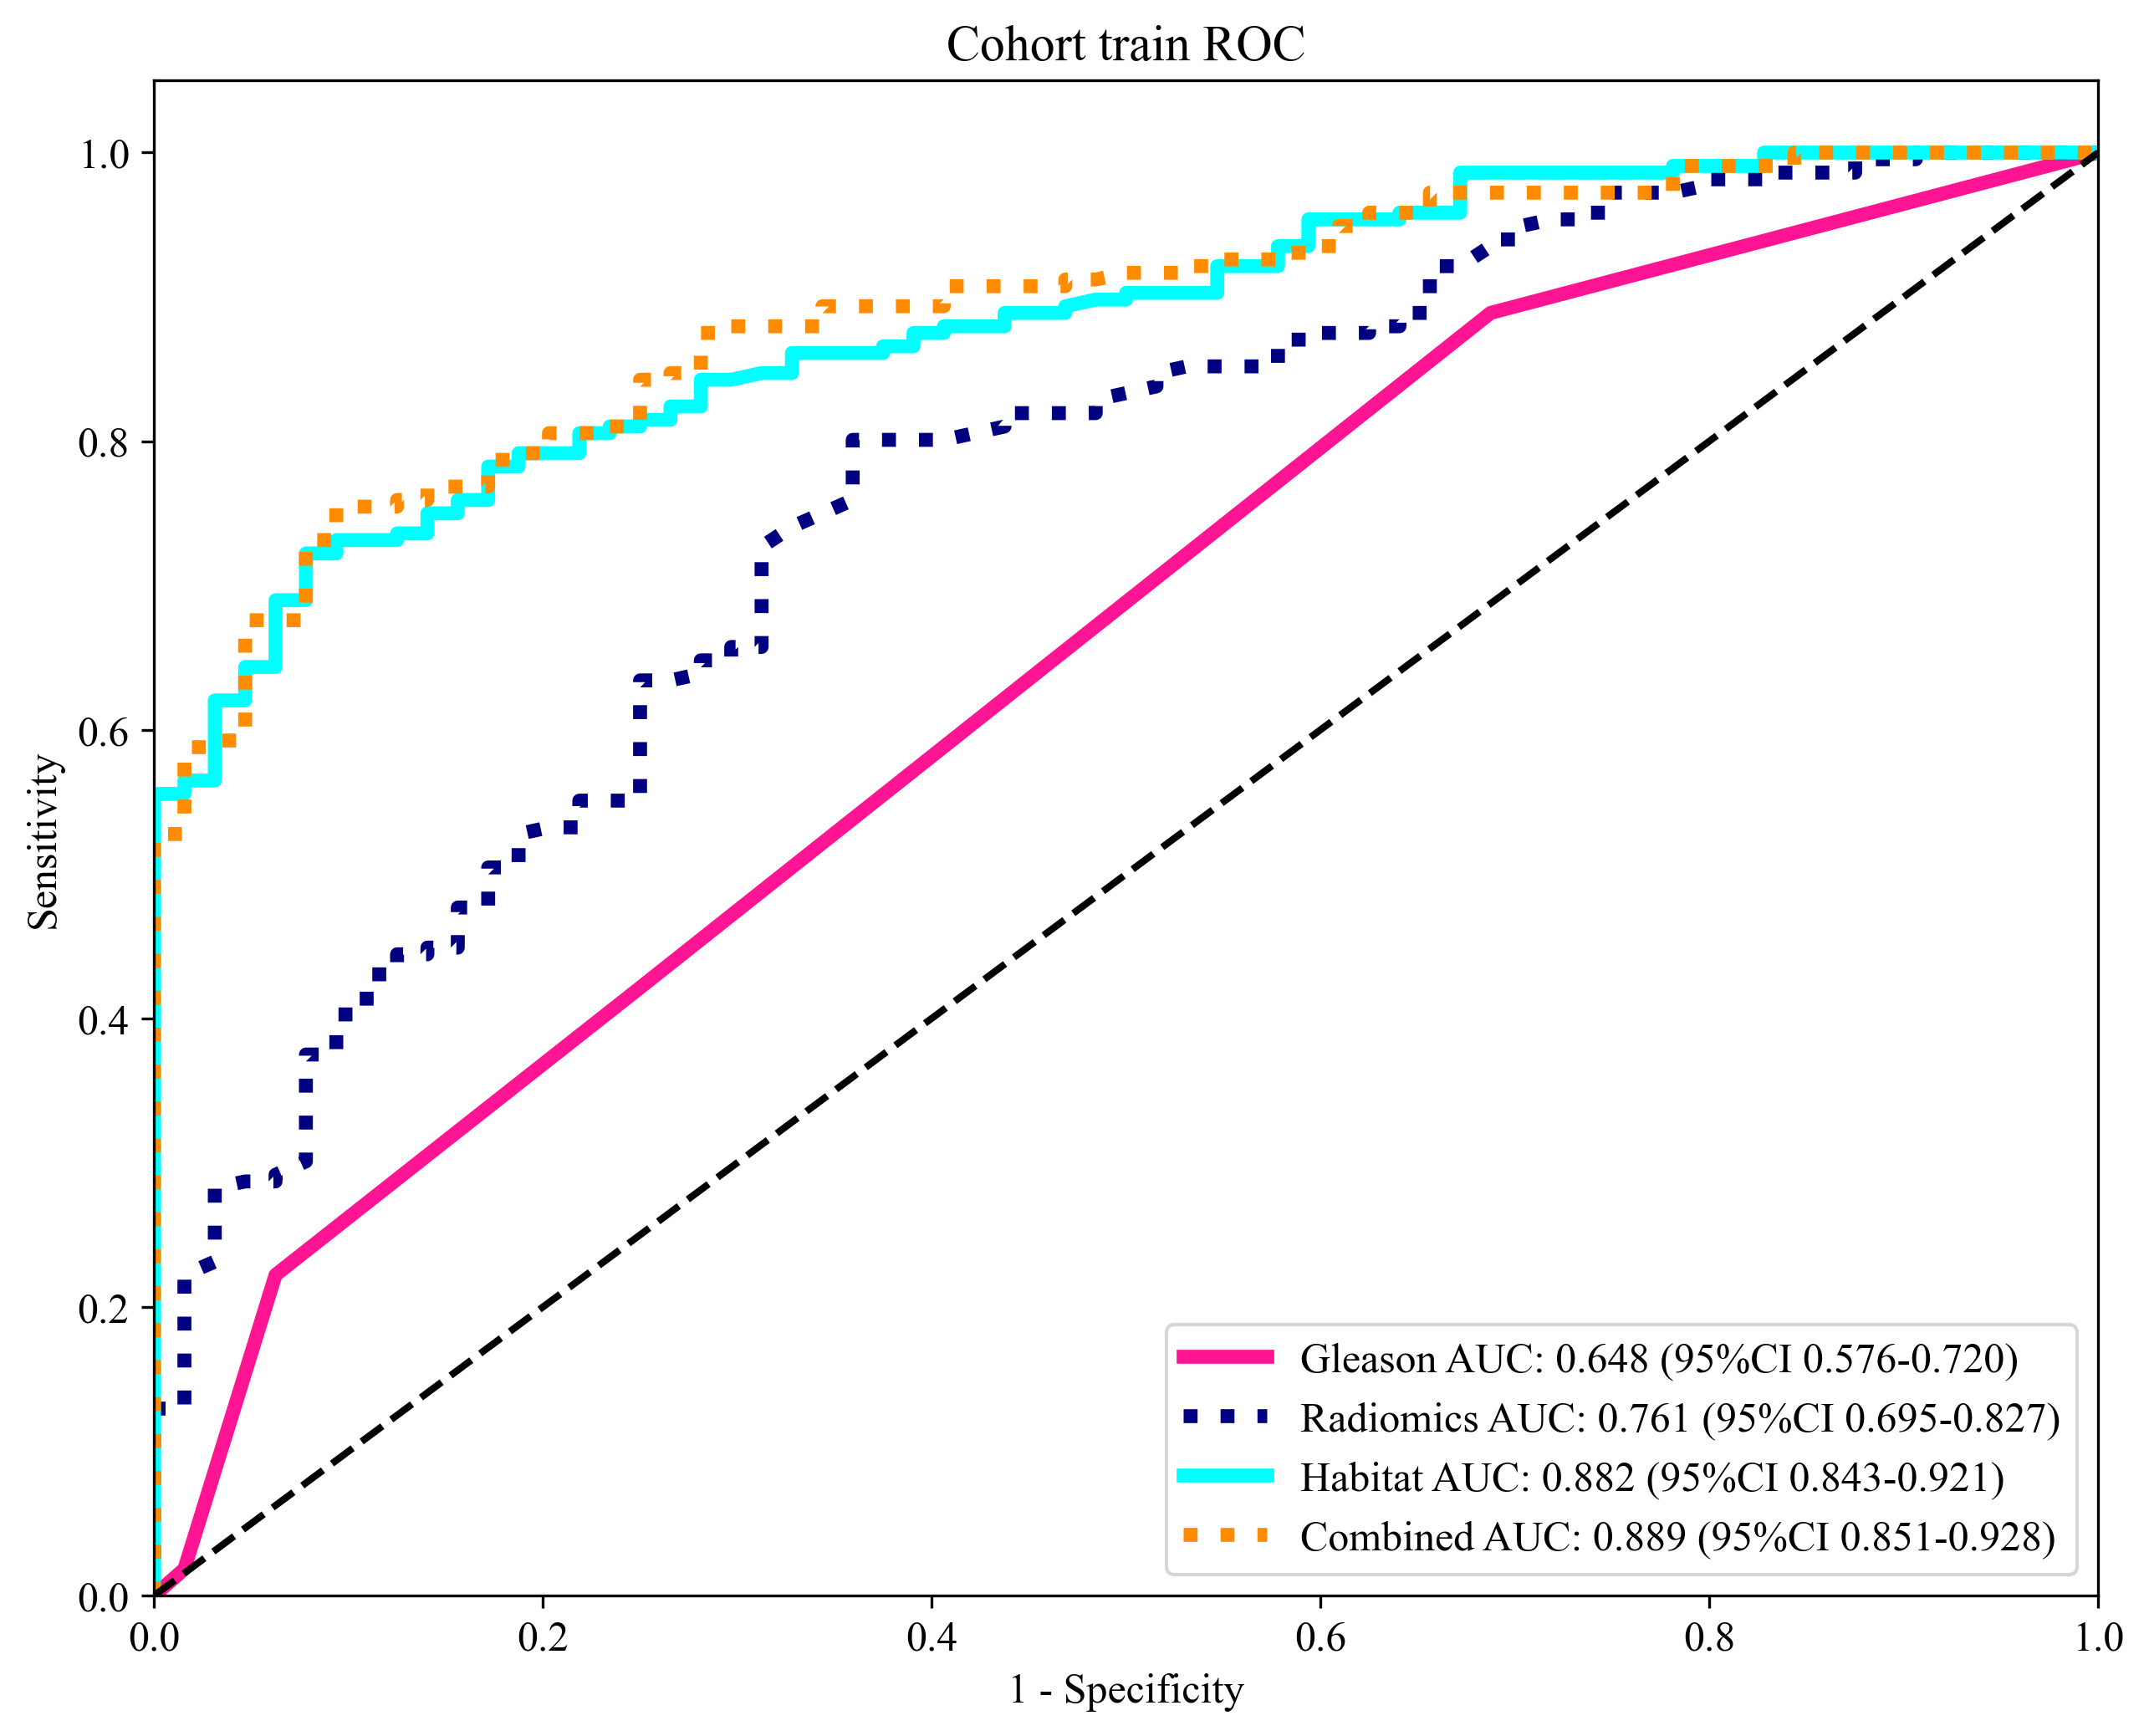

In [19]:
pred_column = [f'{task}-0', f'{task}-1']
Nomo_results = pd.read_csv(f'./results/Nomo_{subset}.csv', header=0)
Nomo_results.columns = ['ID', 'label-9', model_names[-1]]
ALL_results = pd.merge(ALL_results, Nomo_results, on='ID', how='inner')
gt = [np.array(ALL_results[task]) for _ in model_names]
pred_train = [np.array(ALL_results[d]) for d in model_names]
okcomp.comp1.draw_roc(gt, pred_train, labels=model_names, title=f'Cohort {subset} ROC')
plt.savefig(f'img/{subset}_auc.svg')

In [20]:
from onekey_algo.custom.components.metrics import analysis_pred_binary
metric = []
youden = {}
for mname, y, score in zip(model_names, gt, pred_train):
    # 计算验证集指标
    acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y, score, use_youden=False)
    ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
    metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, f"Train"))
    youden[mname] = thres
pd.DataFrame(metric, index=None, columns=['Signature', 'Accuracy', 'AUC', '95% CI', 'Sensitivity', 'Specificity', 
                                          'PPV', 'NPV', 'Precision', 'Recall', 'F1','Threshold', 'Cohort'])

[2024-06-11 16:35:45 - metrics.py: 287]	INFO	use_youden index: False
[2024-06-11 16:35:45 - metrics.py: 287]	INFO	use_youden index: False
[2024-06-11 16:35:45 - metrics.py: 287]	INFO	use_youden index: False
[2024-06-11 16:35:45 - metrics.py: 287]	INFO	use_youden index: False


,Signature,Accuracy,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Precision,Recall,F1,Threshold,Cohort
0,Gleason,0.771,0.648,0.5757 - 0.7200,1.000,0.000,0.771,0.000,0.771,1.000,0.871,7.000,Train
1,Radiomics,0.732,0.761,0.6952 - 0.8266,0.759,0.641,0.877,0.441,0.877,0.759,0.814,0.495,Train
2,Habitat,0.764,0.882,0.8427 - 0.9214,0.736,0.859,0.946,0.491,0.946,0.736,0.828,0.534,Train
3,Combined,0.825,0.889,0.8509 - 0.9276,0.894,0.594,0.881,0.623,0.881,0.894,0.887,0.825,Train


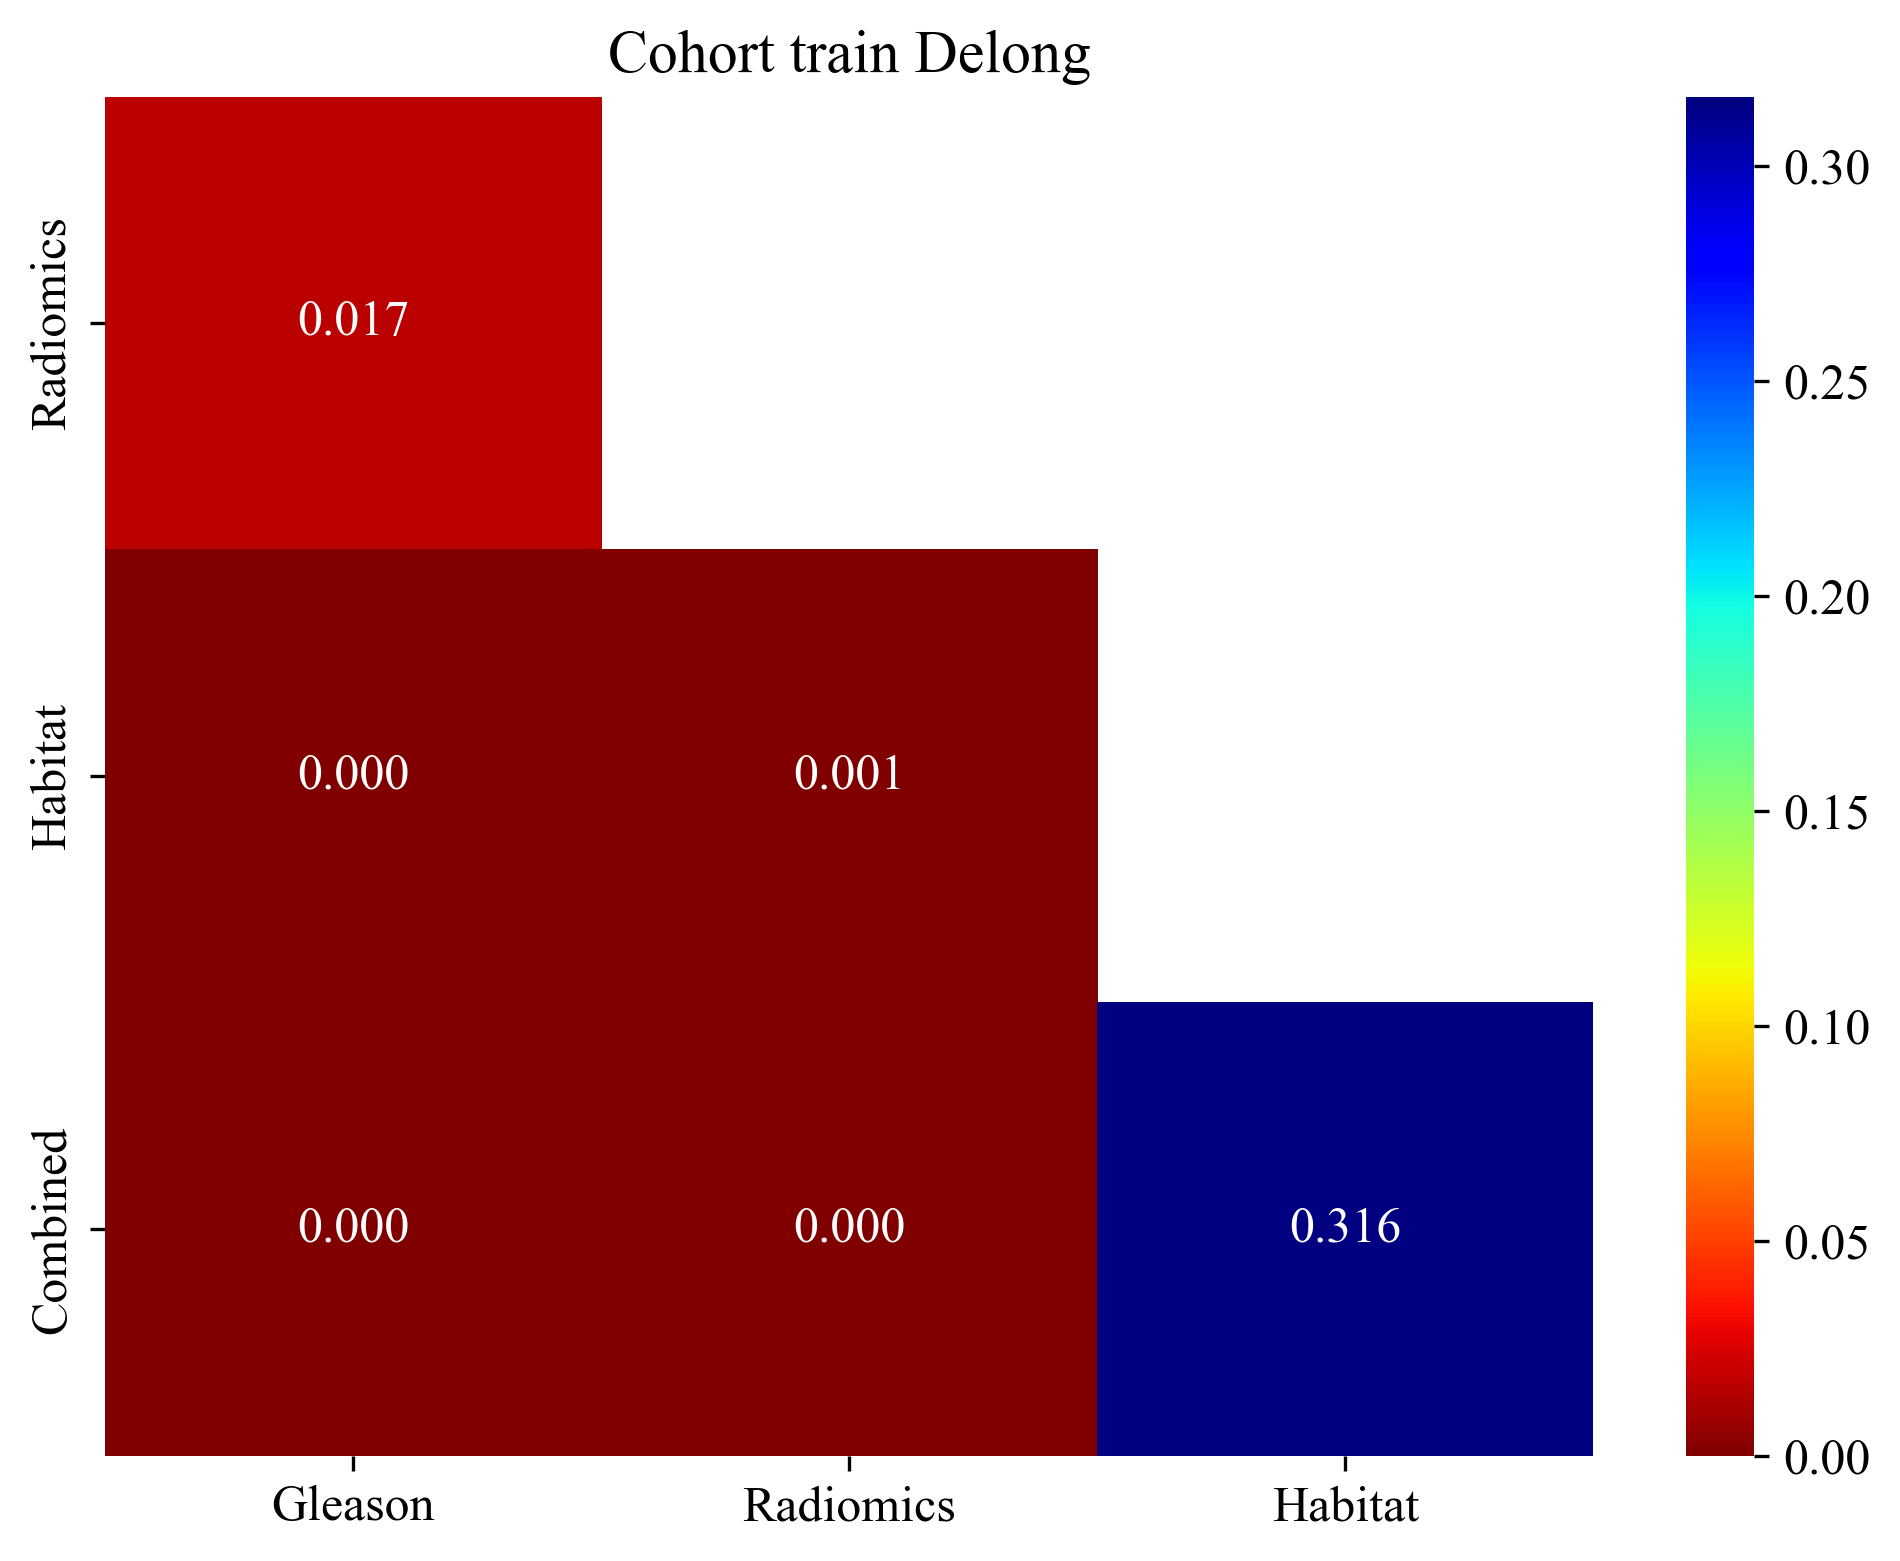

In [21]:
from onekey_algo.custom.components.delong import delong_roc_test
from onekey_algo.custom.components.comp1 import draw_matrix

delong = []
delong_columns = []
this_delong = []
plt.figure(figsize=(8, 6))
cm = np.zeros((len(model_names), len(model_names)))
for i, mni in enumerate(model_names):
    for j, mnj in enumerate(model_names):
        if i <= j:
            cm[i][j] = np.nan
        else:
            cm[i][j] = delong_roc_test(ALL_results[task], ALL_results[mni], ALL_results[mnj])[0][0]
cm = pd.DataFrame(cm[1:, :-1], index=model_names[1:], columns=model_names[:-1])
draw_matrix(cm, annot=True, cmap='jet_r', cbar=True)
plt.title(f'Cohort {subset} Delong')
plt.savefig(f'img/all_delong_each_cohort_{subset}.svg', bbox_inches = 'tight')
plt.show()

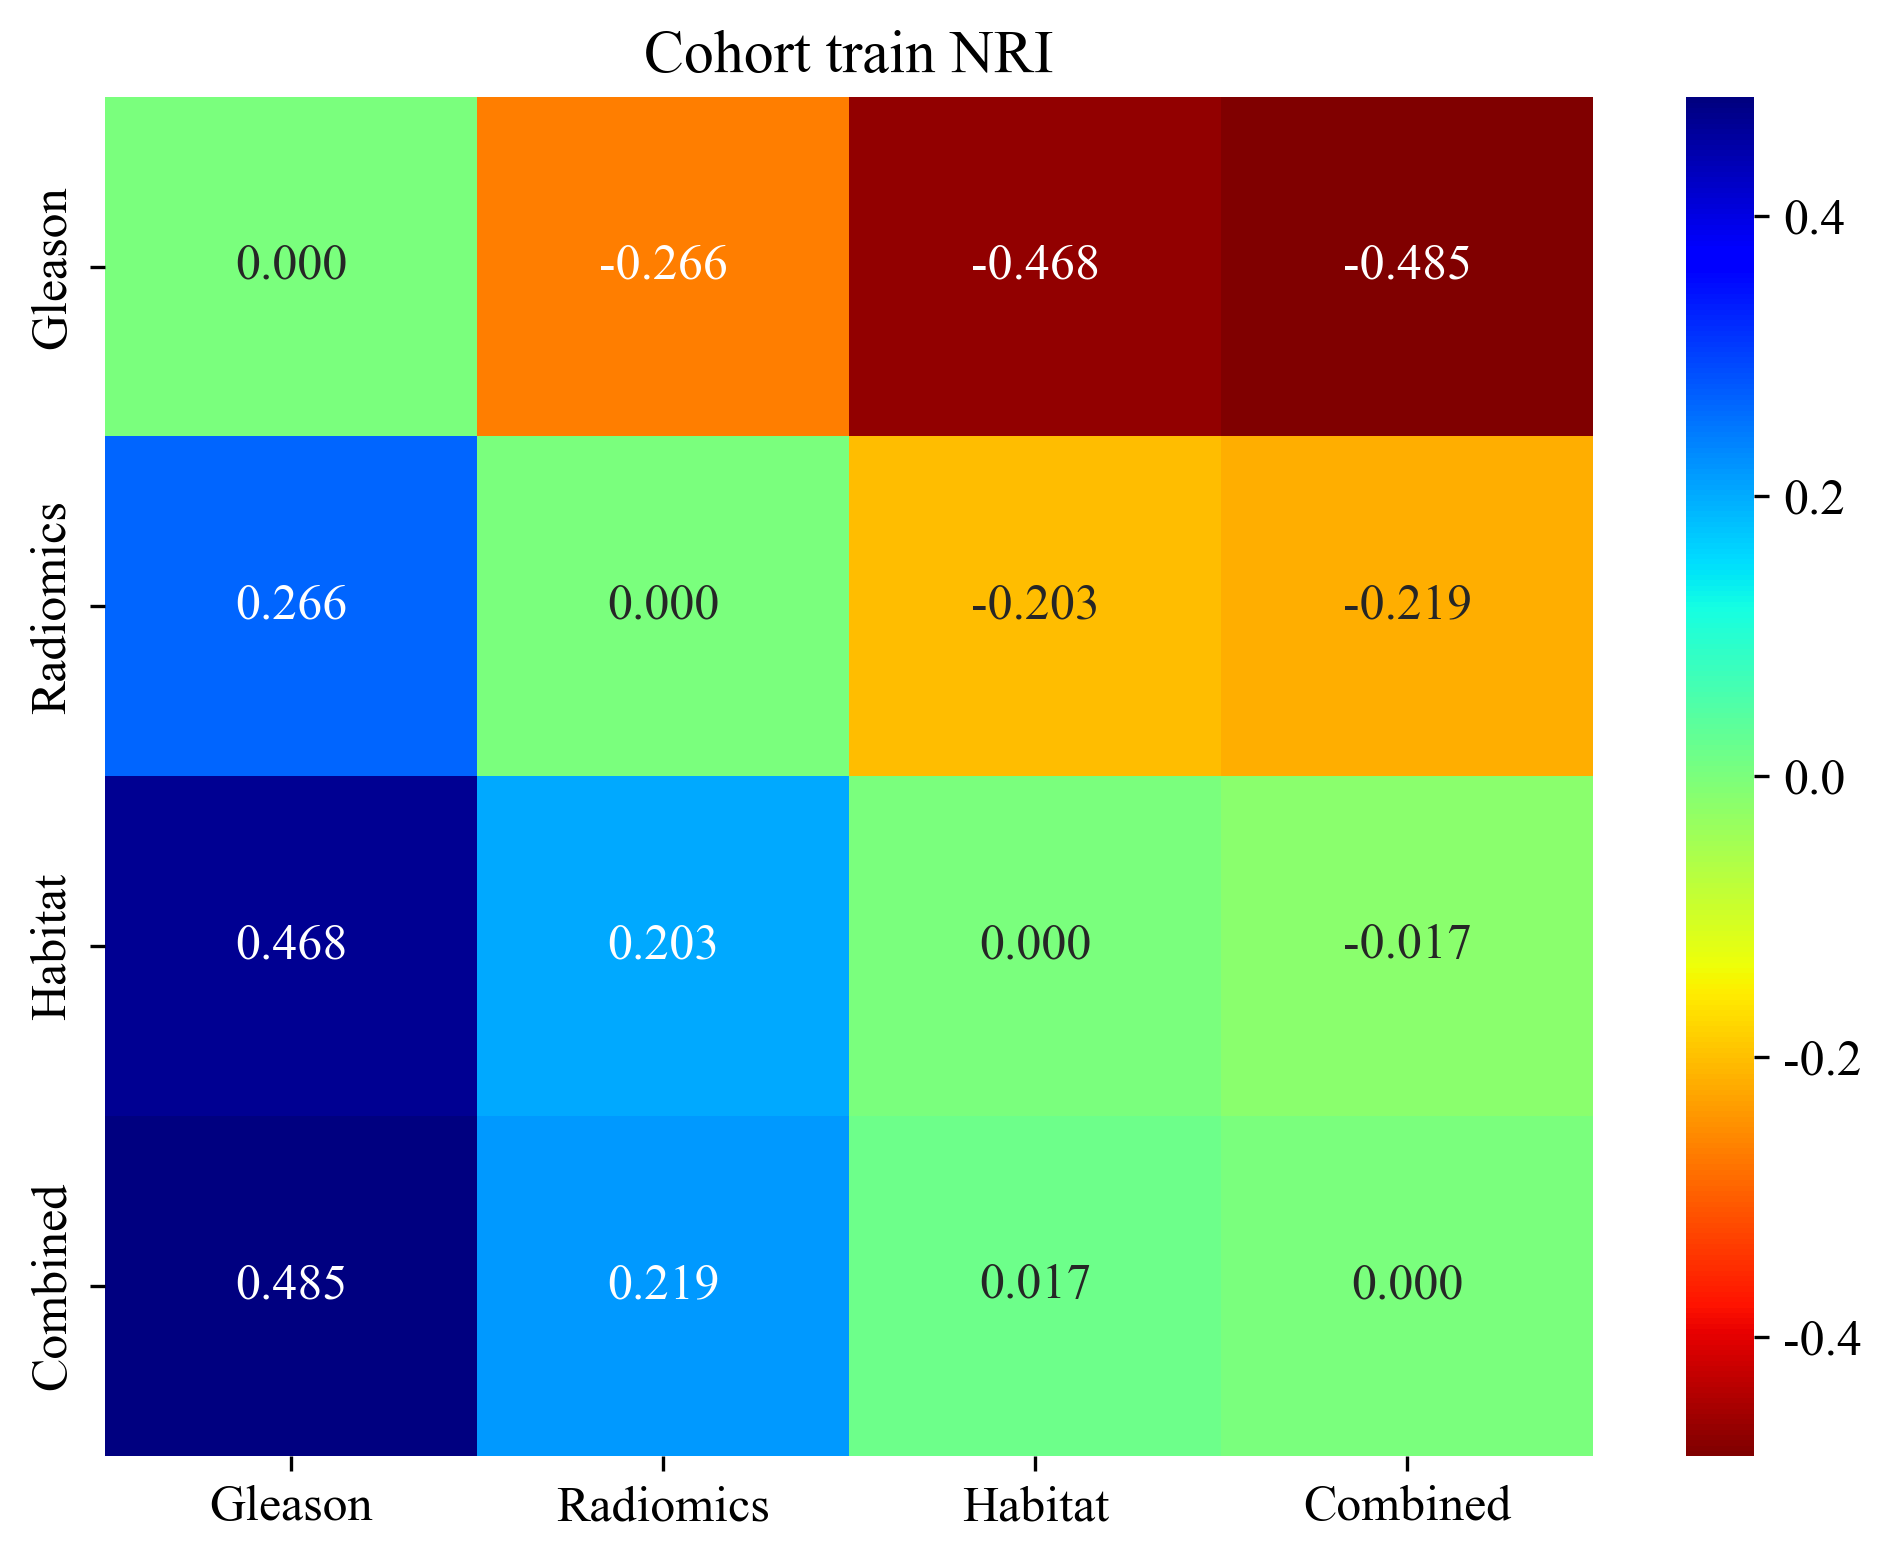

In [22]:
from onekey_algo.custom.components.delong import delong_roc_test
from onekey_algo.custom.components.metrics import NRI, IDI

delong = []
delong_columns = []
this_delong = []
plt.figure(figsize=(8, 6))
cm = np.zeros((len(model_names), len(model_names)))
for i, mni in enumerate(model_names):
    for j, mnj in enumerate(model_names):
        cm[i][j] = NRI(ALL_results[mni] > youden[mni], ALL_results[mnj] > youden[mnj], ALL_results[task])
cm = pd.DataFrame(cm, index=model_names, columns=model_names)
draw_matrix(cm, annot=True, cmap='jet_r', cbar=True)
plt.title(f'Cohort {subset} NRI')
plt.savefig(f'img/all_NRI_each_cohort_{subset}.svg', bbox_inches = 'tight')
plt.show()

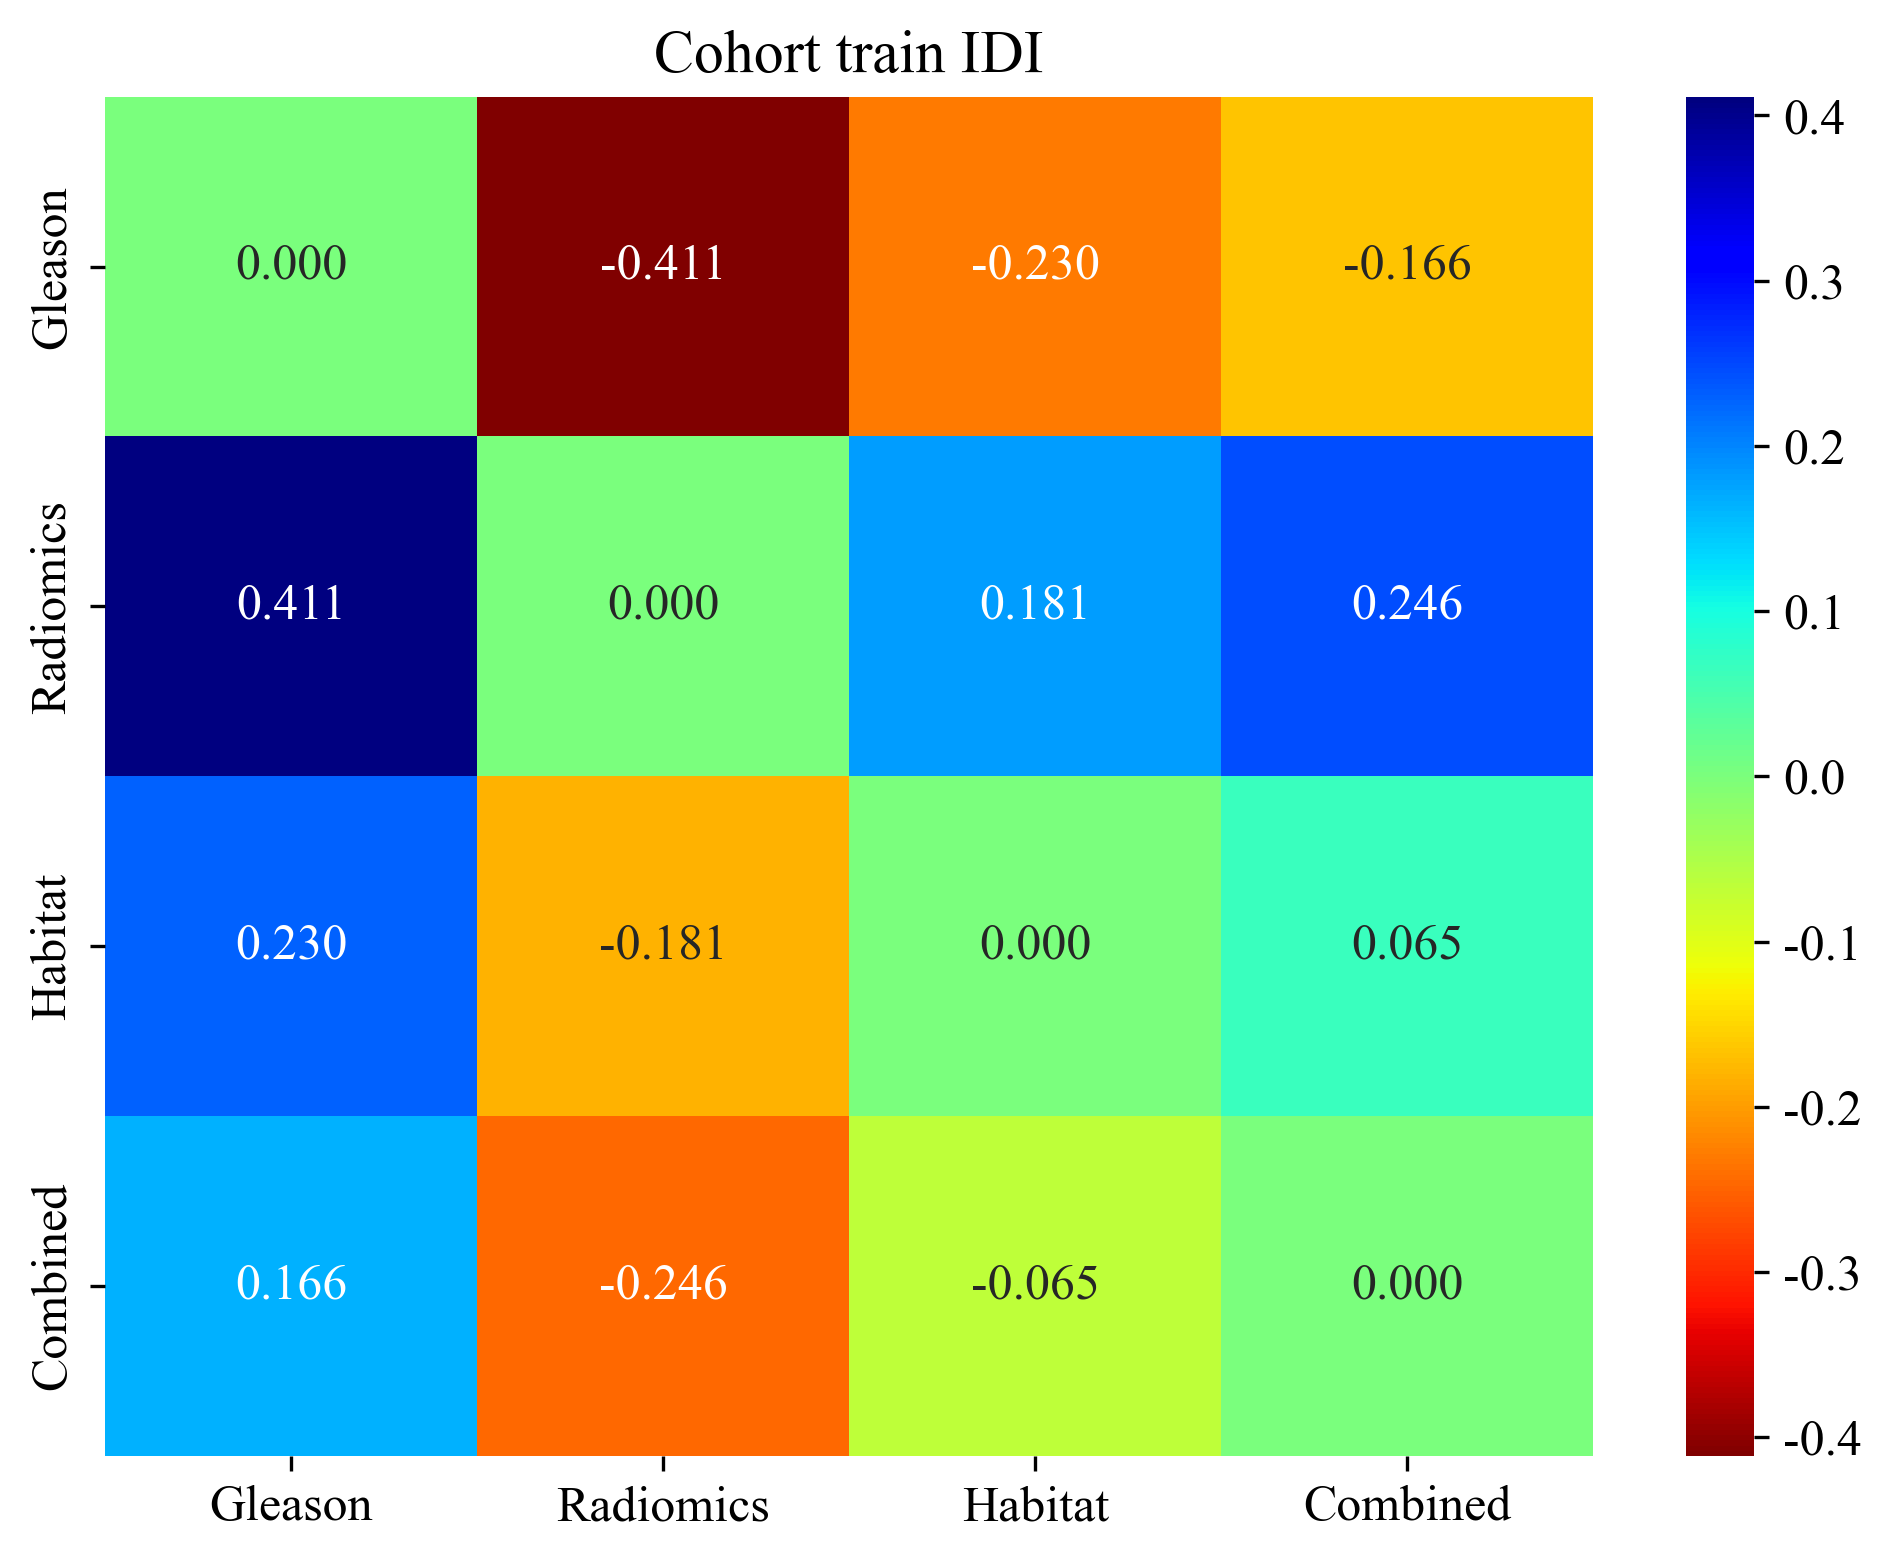

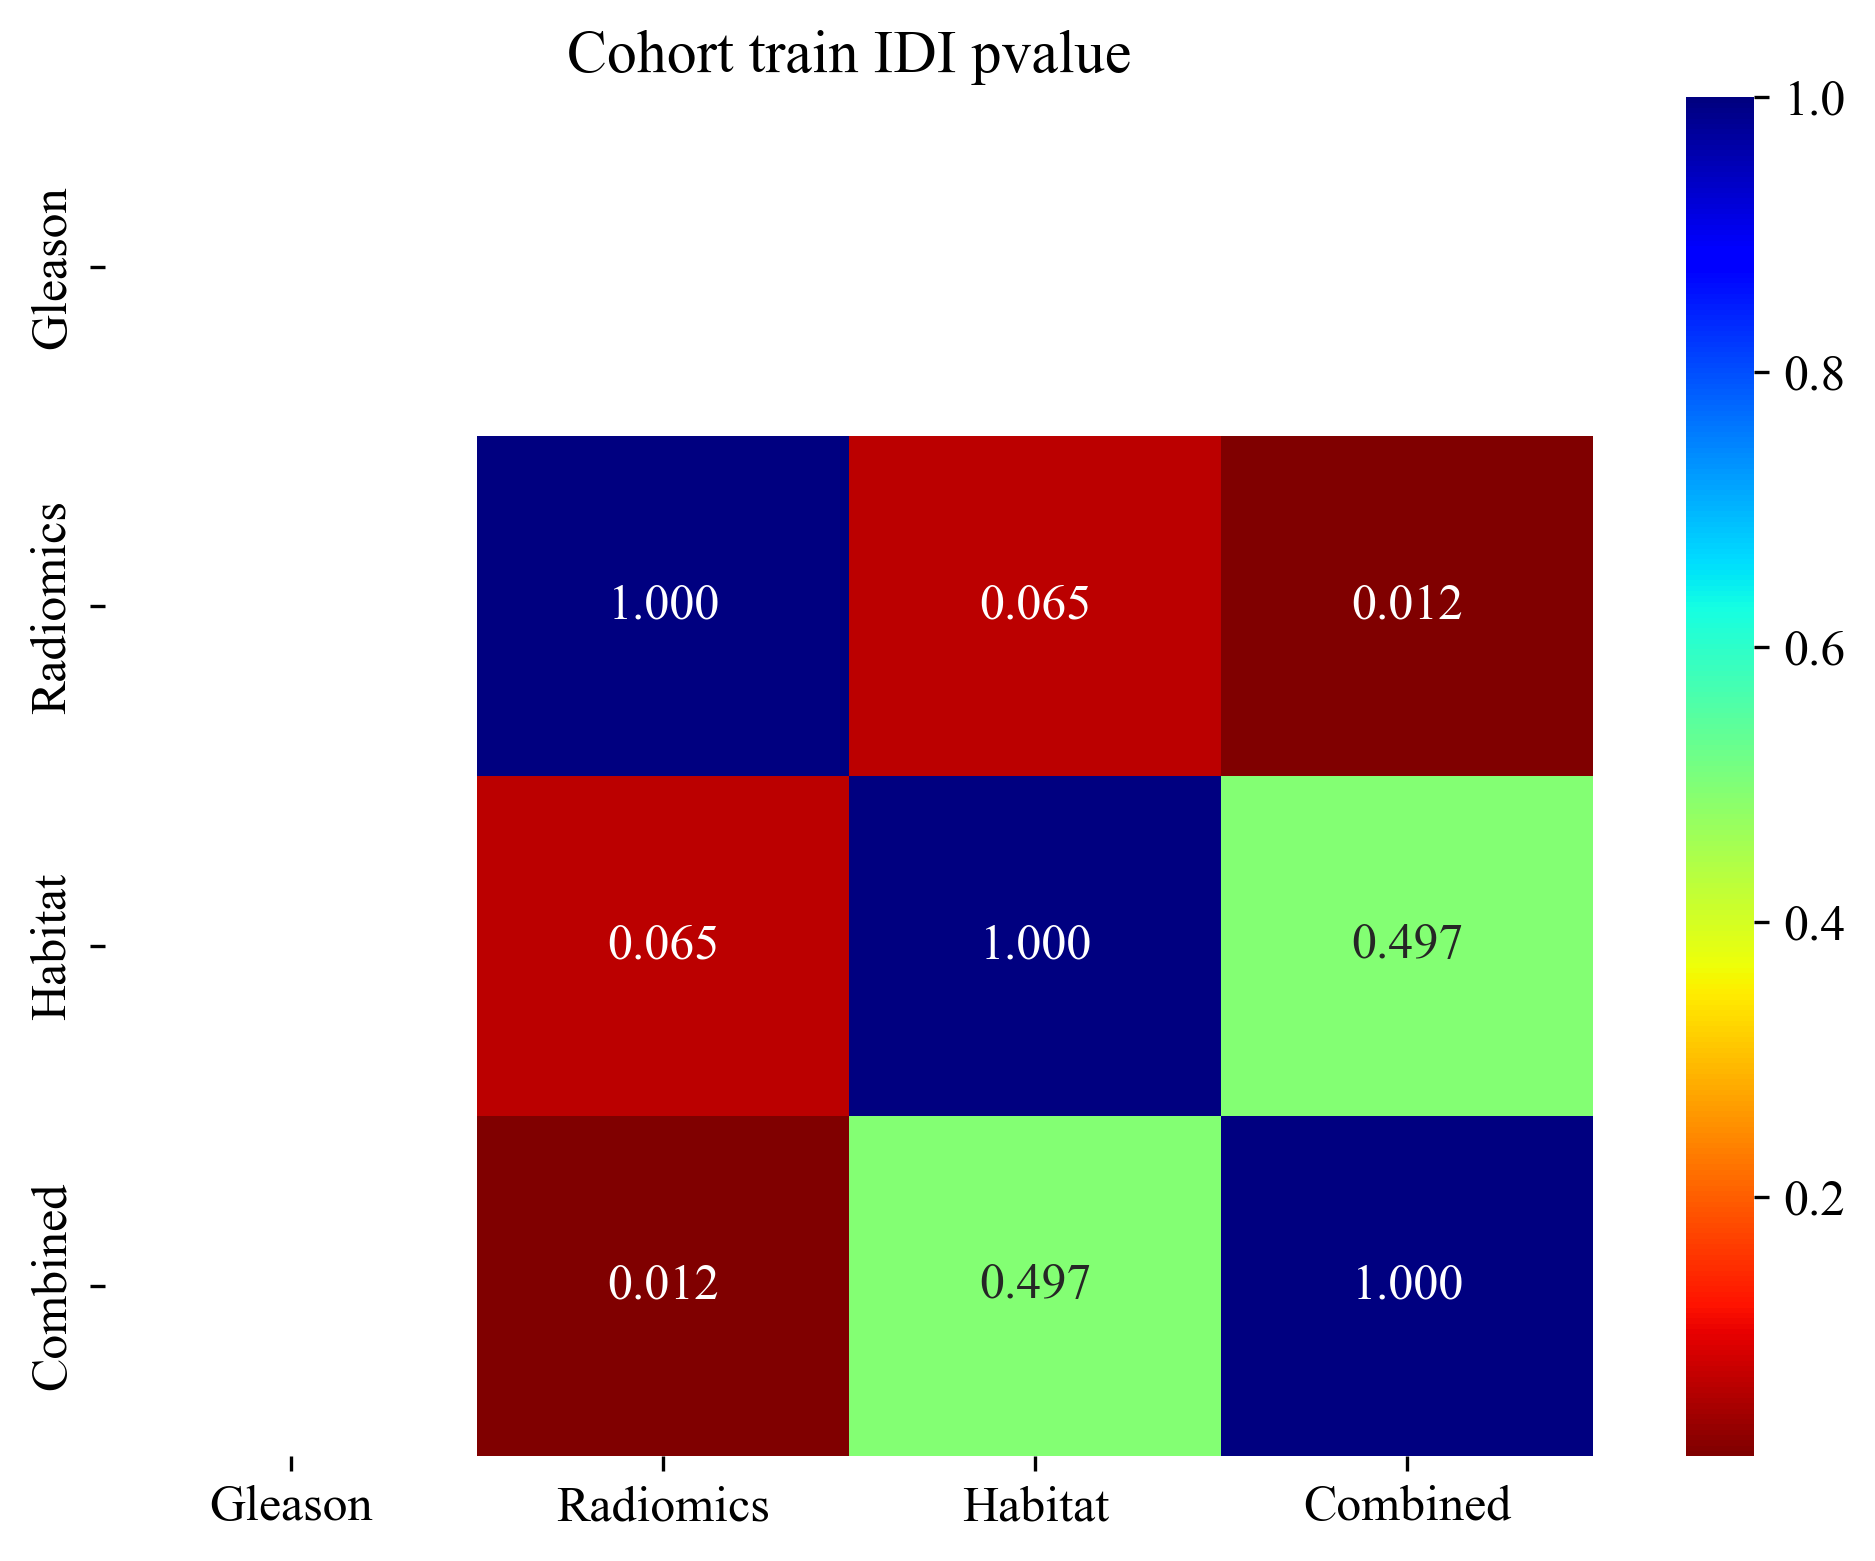

In [23]:
from onekey_algo.custom.components.delong import delong_roc_test
from onekey_algo.custom.components.metrics import NRI, IDI

delong = []
delong_columns = []
this_delong = []
cm = np.zeros((len(model_names), len(model_names)))
p = np.zeros((len(model_names), len(model_names)))
for i, mni in enumerate(model_names):
    for j, mnj in enumerate(model_names):
        cm[i][j], p[i][j] = IDI(ALL_results[mni], ALL_results[mnj], ALL_results[task], with_p=True)

for d, n in zip([cm, p], ['IDI', 'IDI pvalue']):
    plt.figure(figsize=(8, 6))
    d = pd.DataFrame(d, index=model_names, columns=model_names)
    draw_matrix(d, annot=True, cmap='jet_r', cbar=True)
    plt.title(f'Cohort {subset} {n}')
    plt.savefig(f'img/all_{n}_each_cohort_{subset}.svg', bbox_inches = 'tight')
    plt.show()

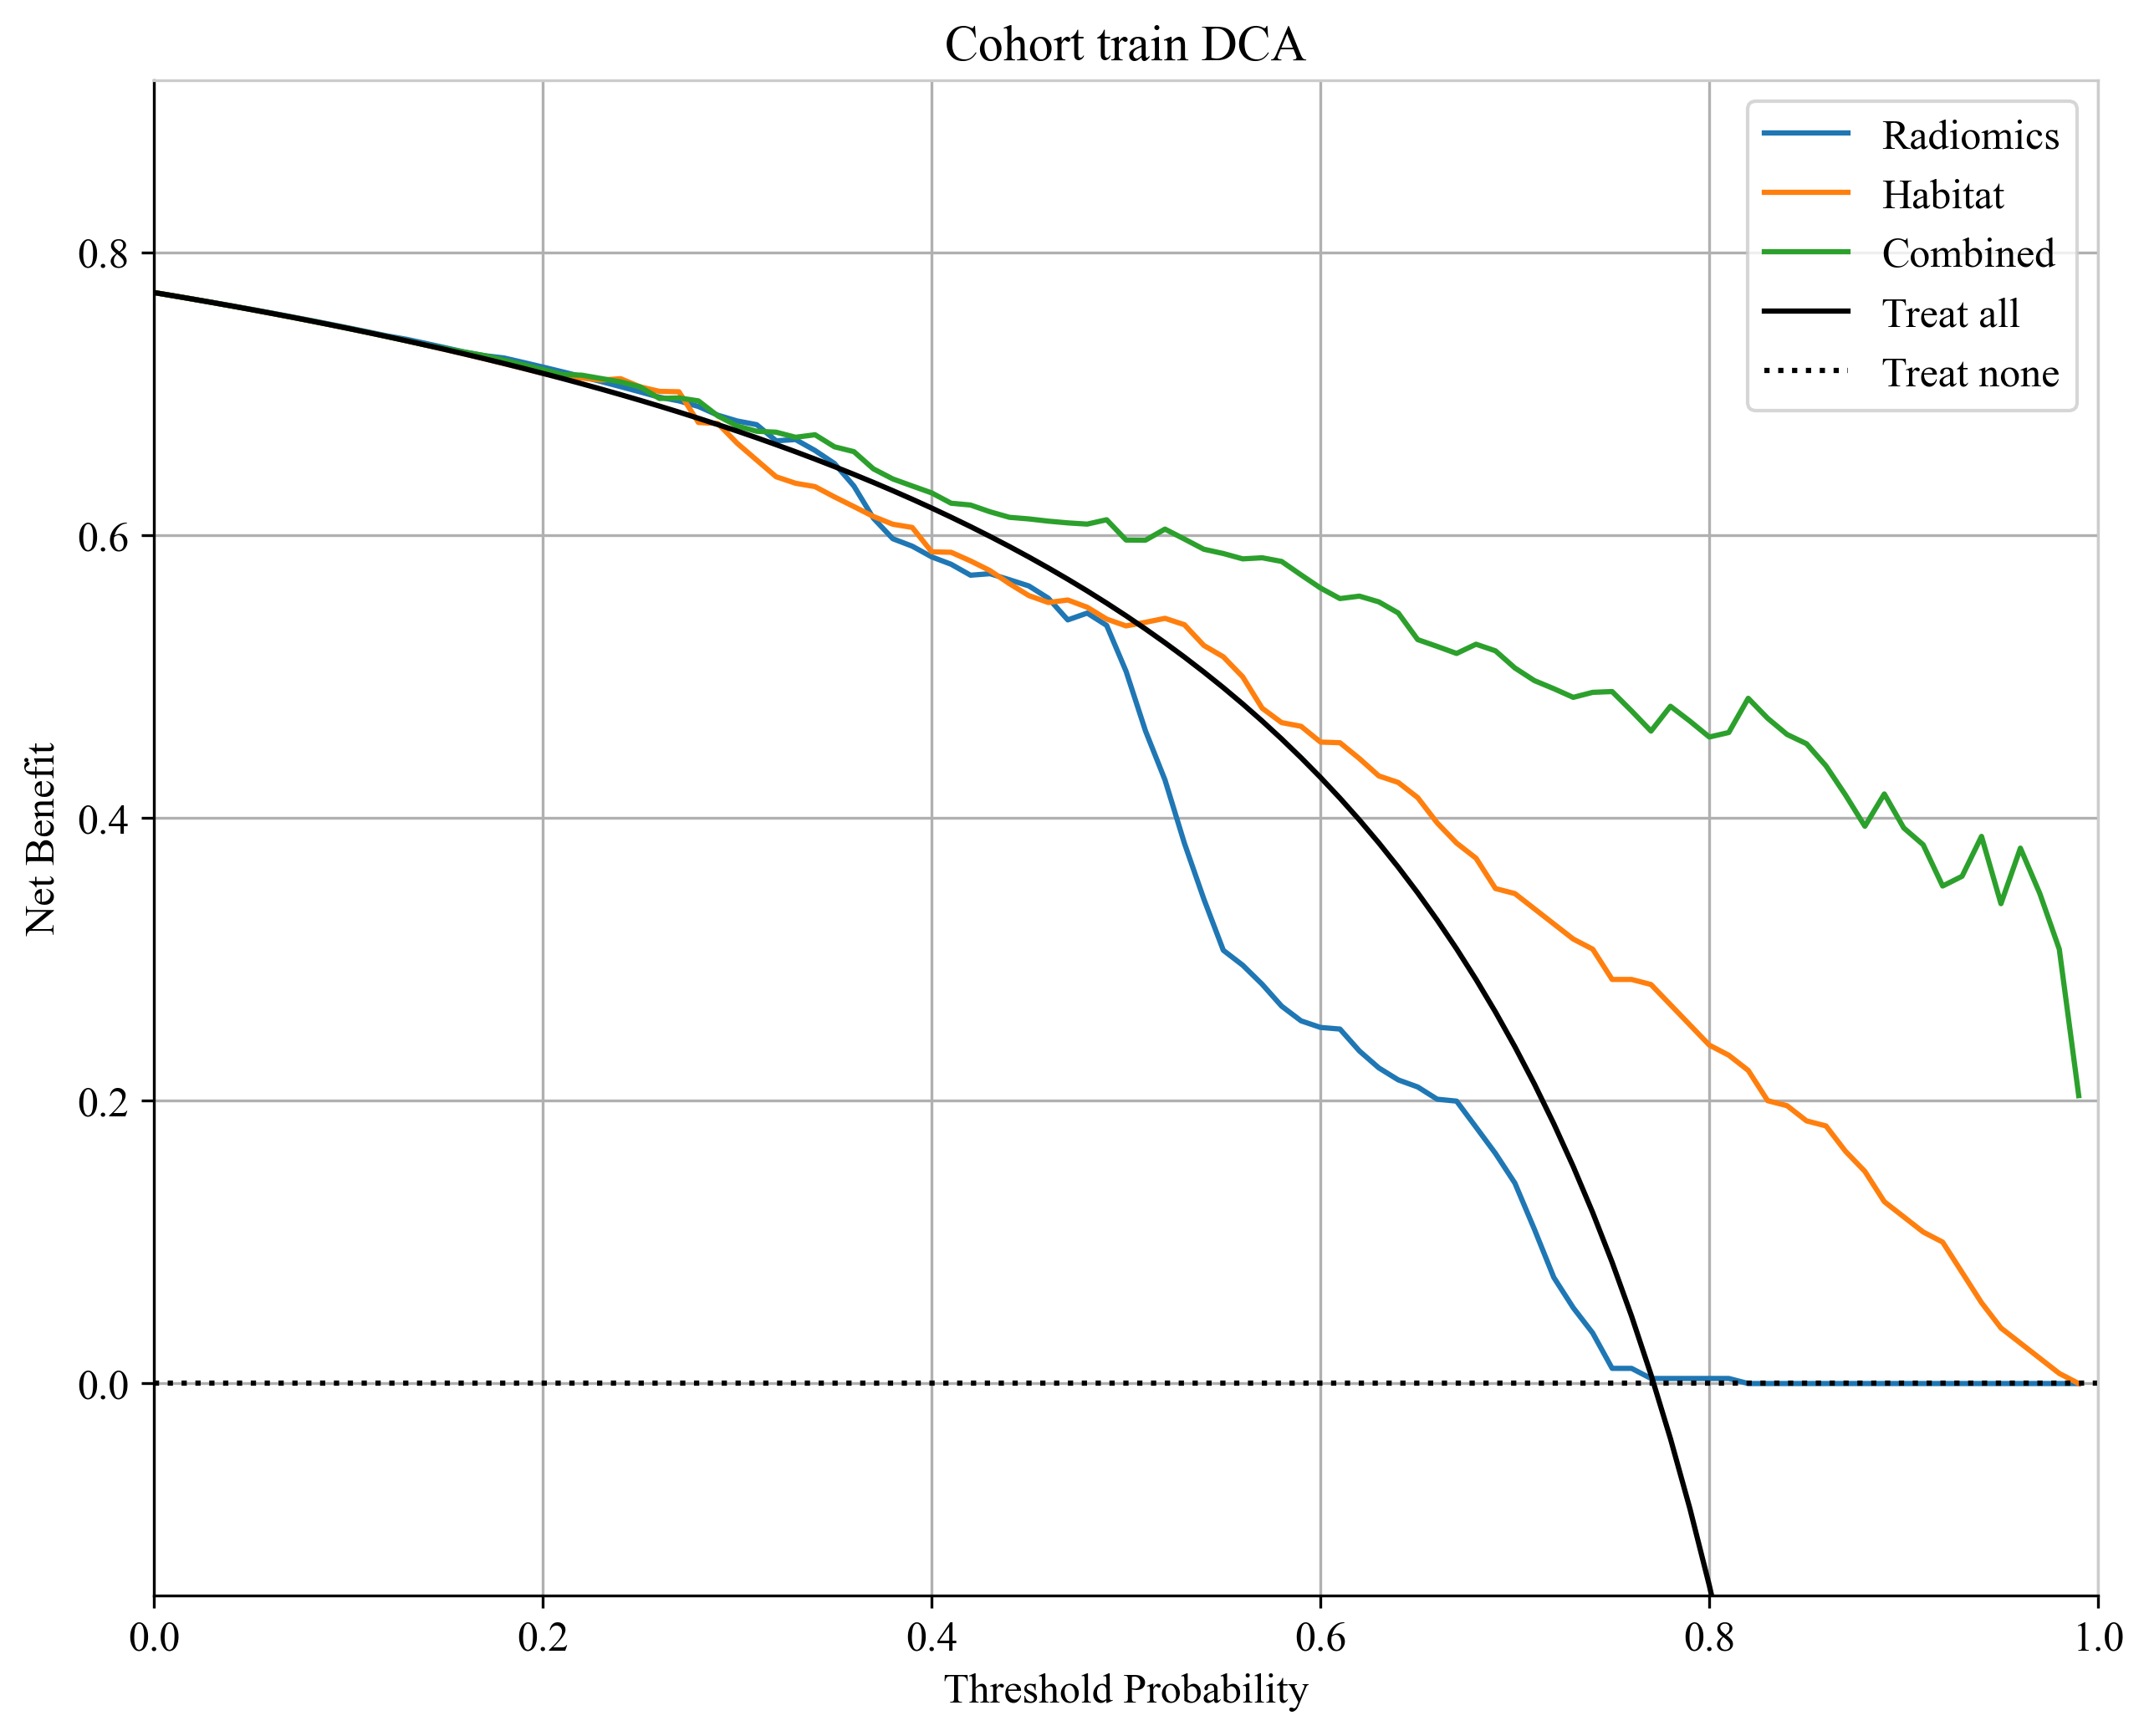

In [24]:
from onekey_algo.custom.components.comp1 import plot_DCA
plot_DCA([ALL_results[model_name] for model_name in model_names[1:]], 
         ALL_results[task], title=f'Cohort {subset} DCA', labels=model_names[1:], y_min=-0.15)
plt.savefig(f'img/{subset}_dca.svg')

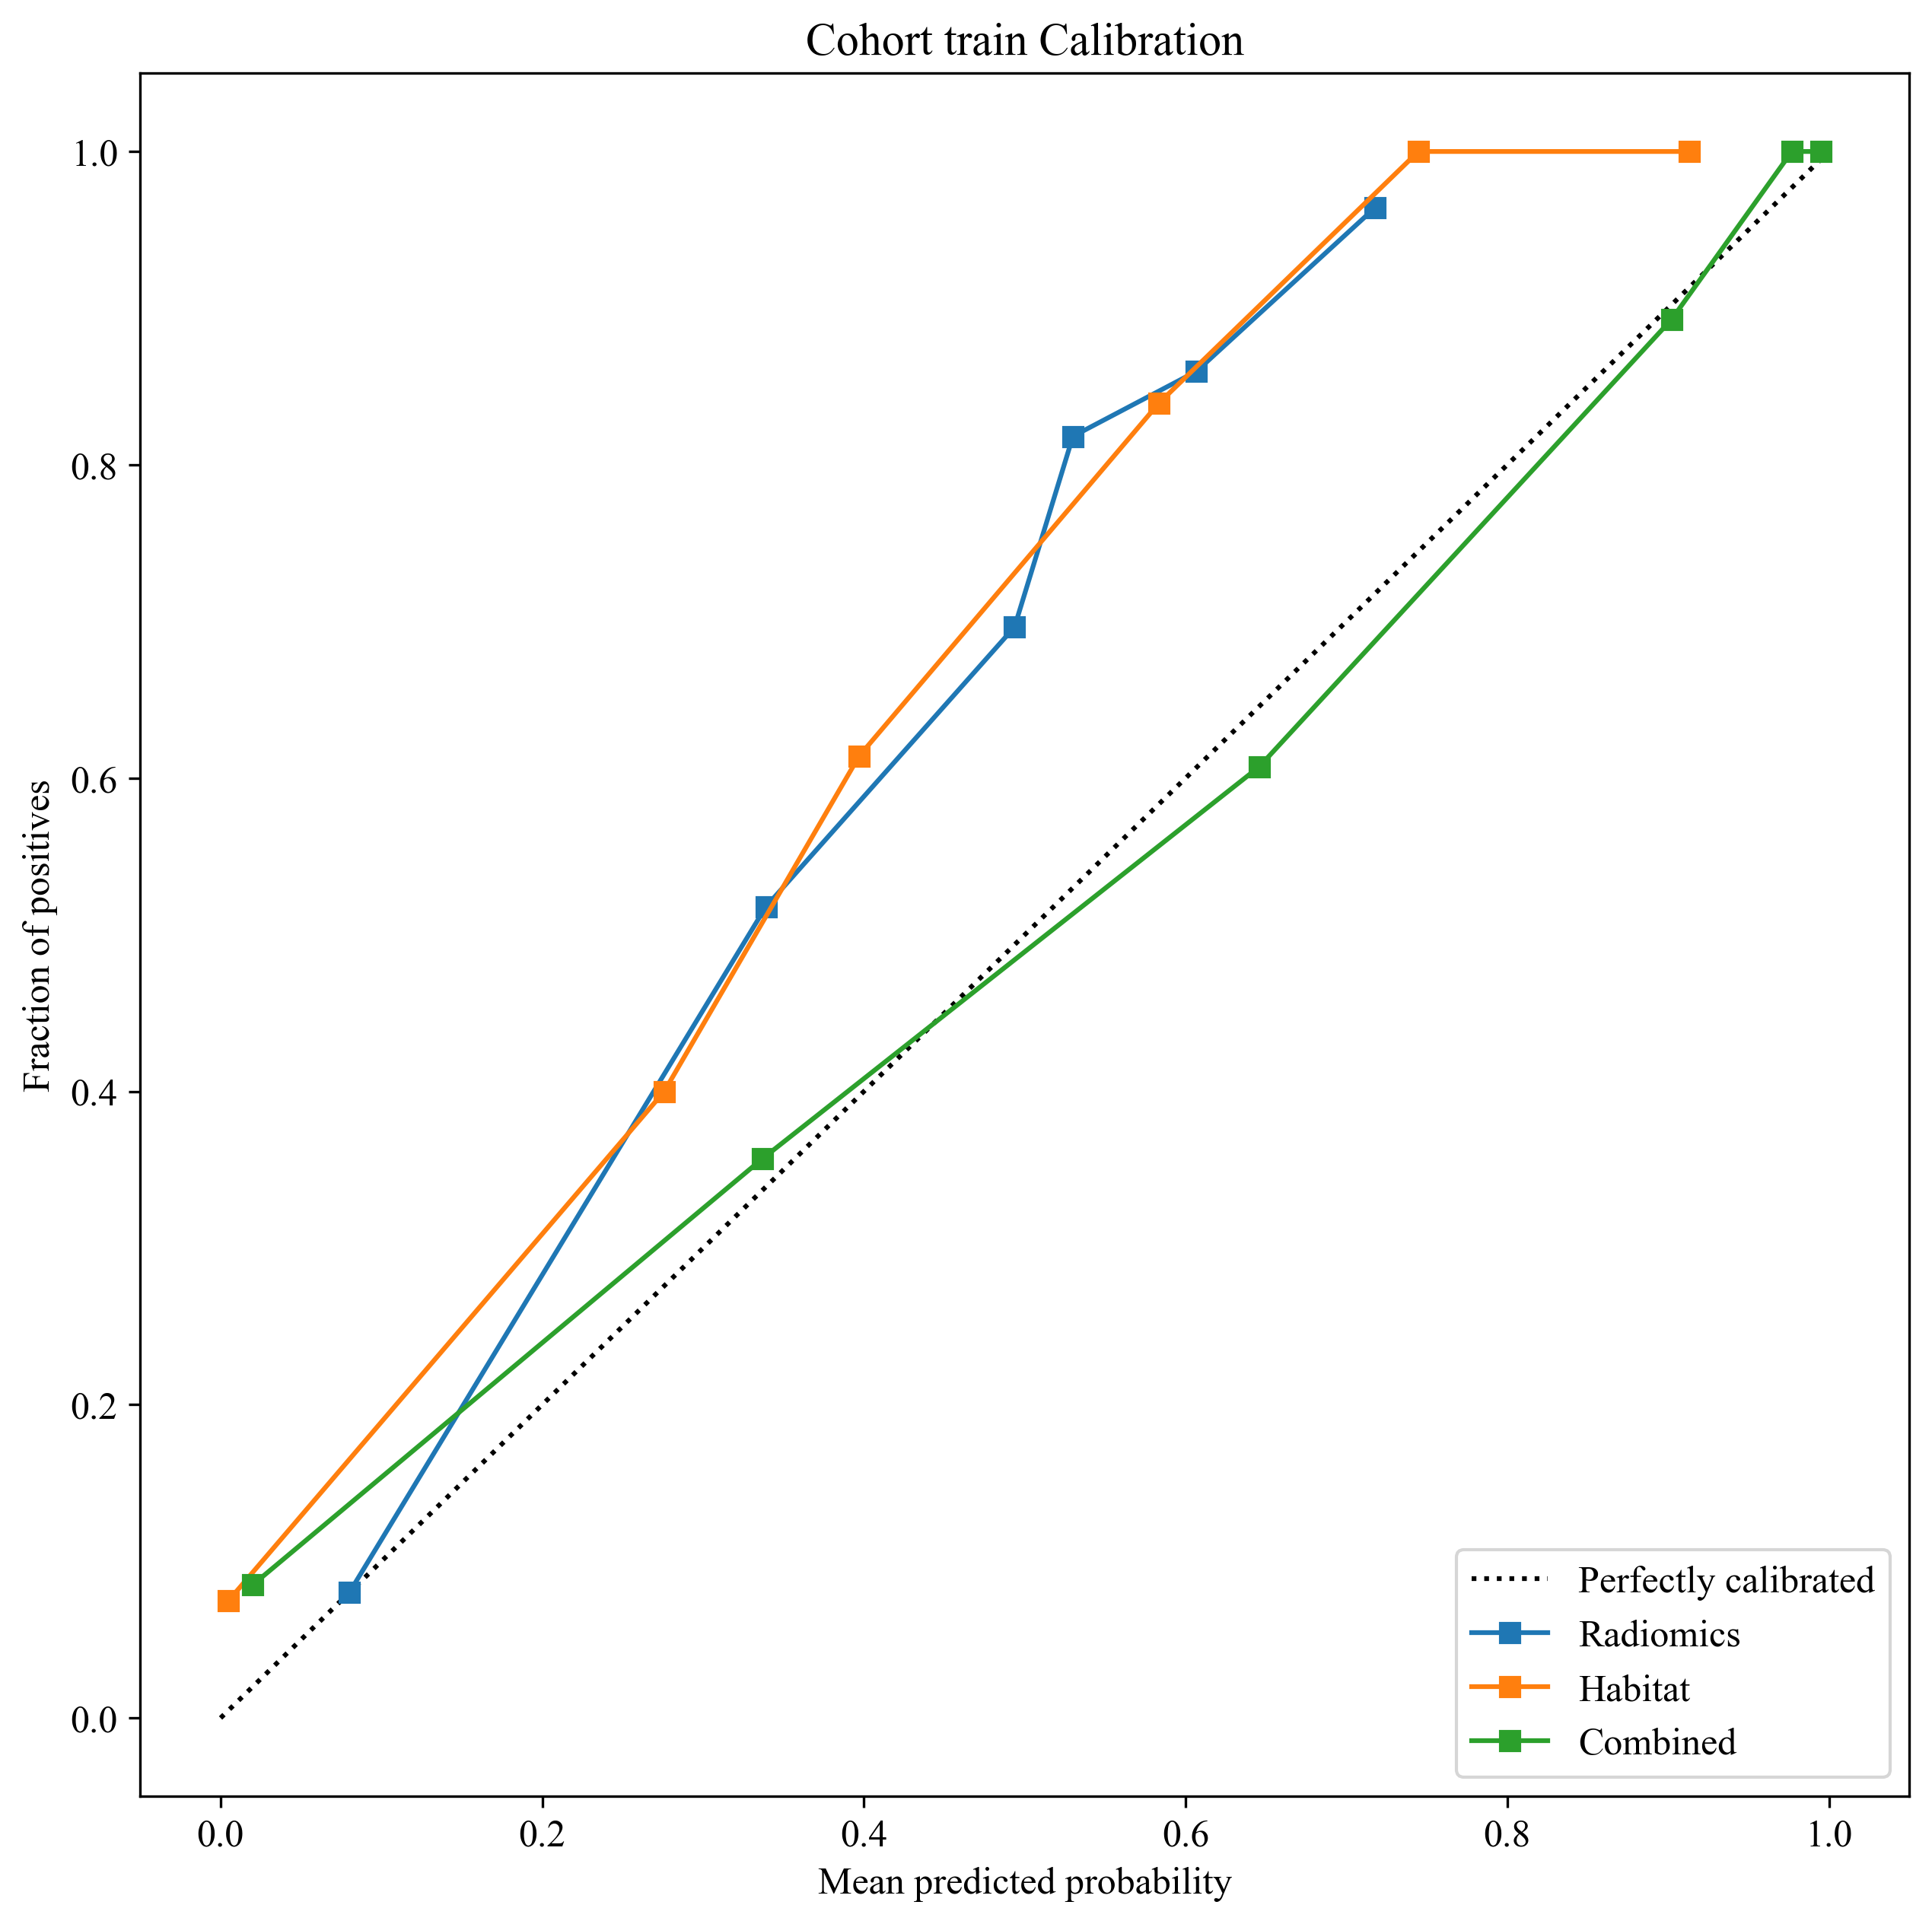

In [25]:
from onekey_algo.custom.components.comp1 import draw_calibration
draw_calibration(pred_scores=pred_train[1:], n_bins=5, remap=False, add_0=True,
                 y_test=gt[1:], model_names=model_names[1:])
plt.title(f"Cohort {subset} Calibration")
plt.savefig(f'img/{subset}_cali.svg')

In [26]:
from onekey_algo.custom.components import stats

hosmer = []
hosmer.append([stats.hosmer_lemeshow_test(y_true, y_pred, bins=20, remap=False) 
              for fn, y_true, y_pred in zip(model_names, gt, pred_train)])
pd.DataFrame(hosmer, columns=model_names)

,Gleason,Radiomics,Habitat,Combined
0,1.0,1.402e-10,7.766e-07,0.719


# 绘制Nomogram

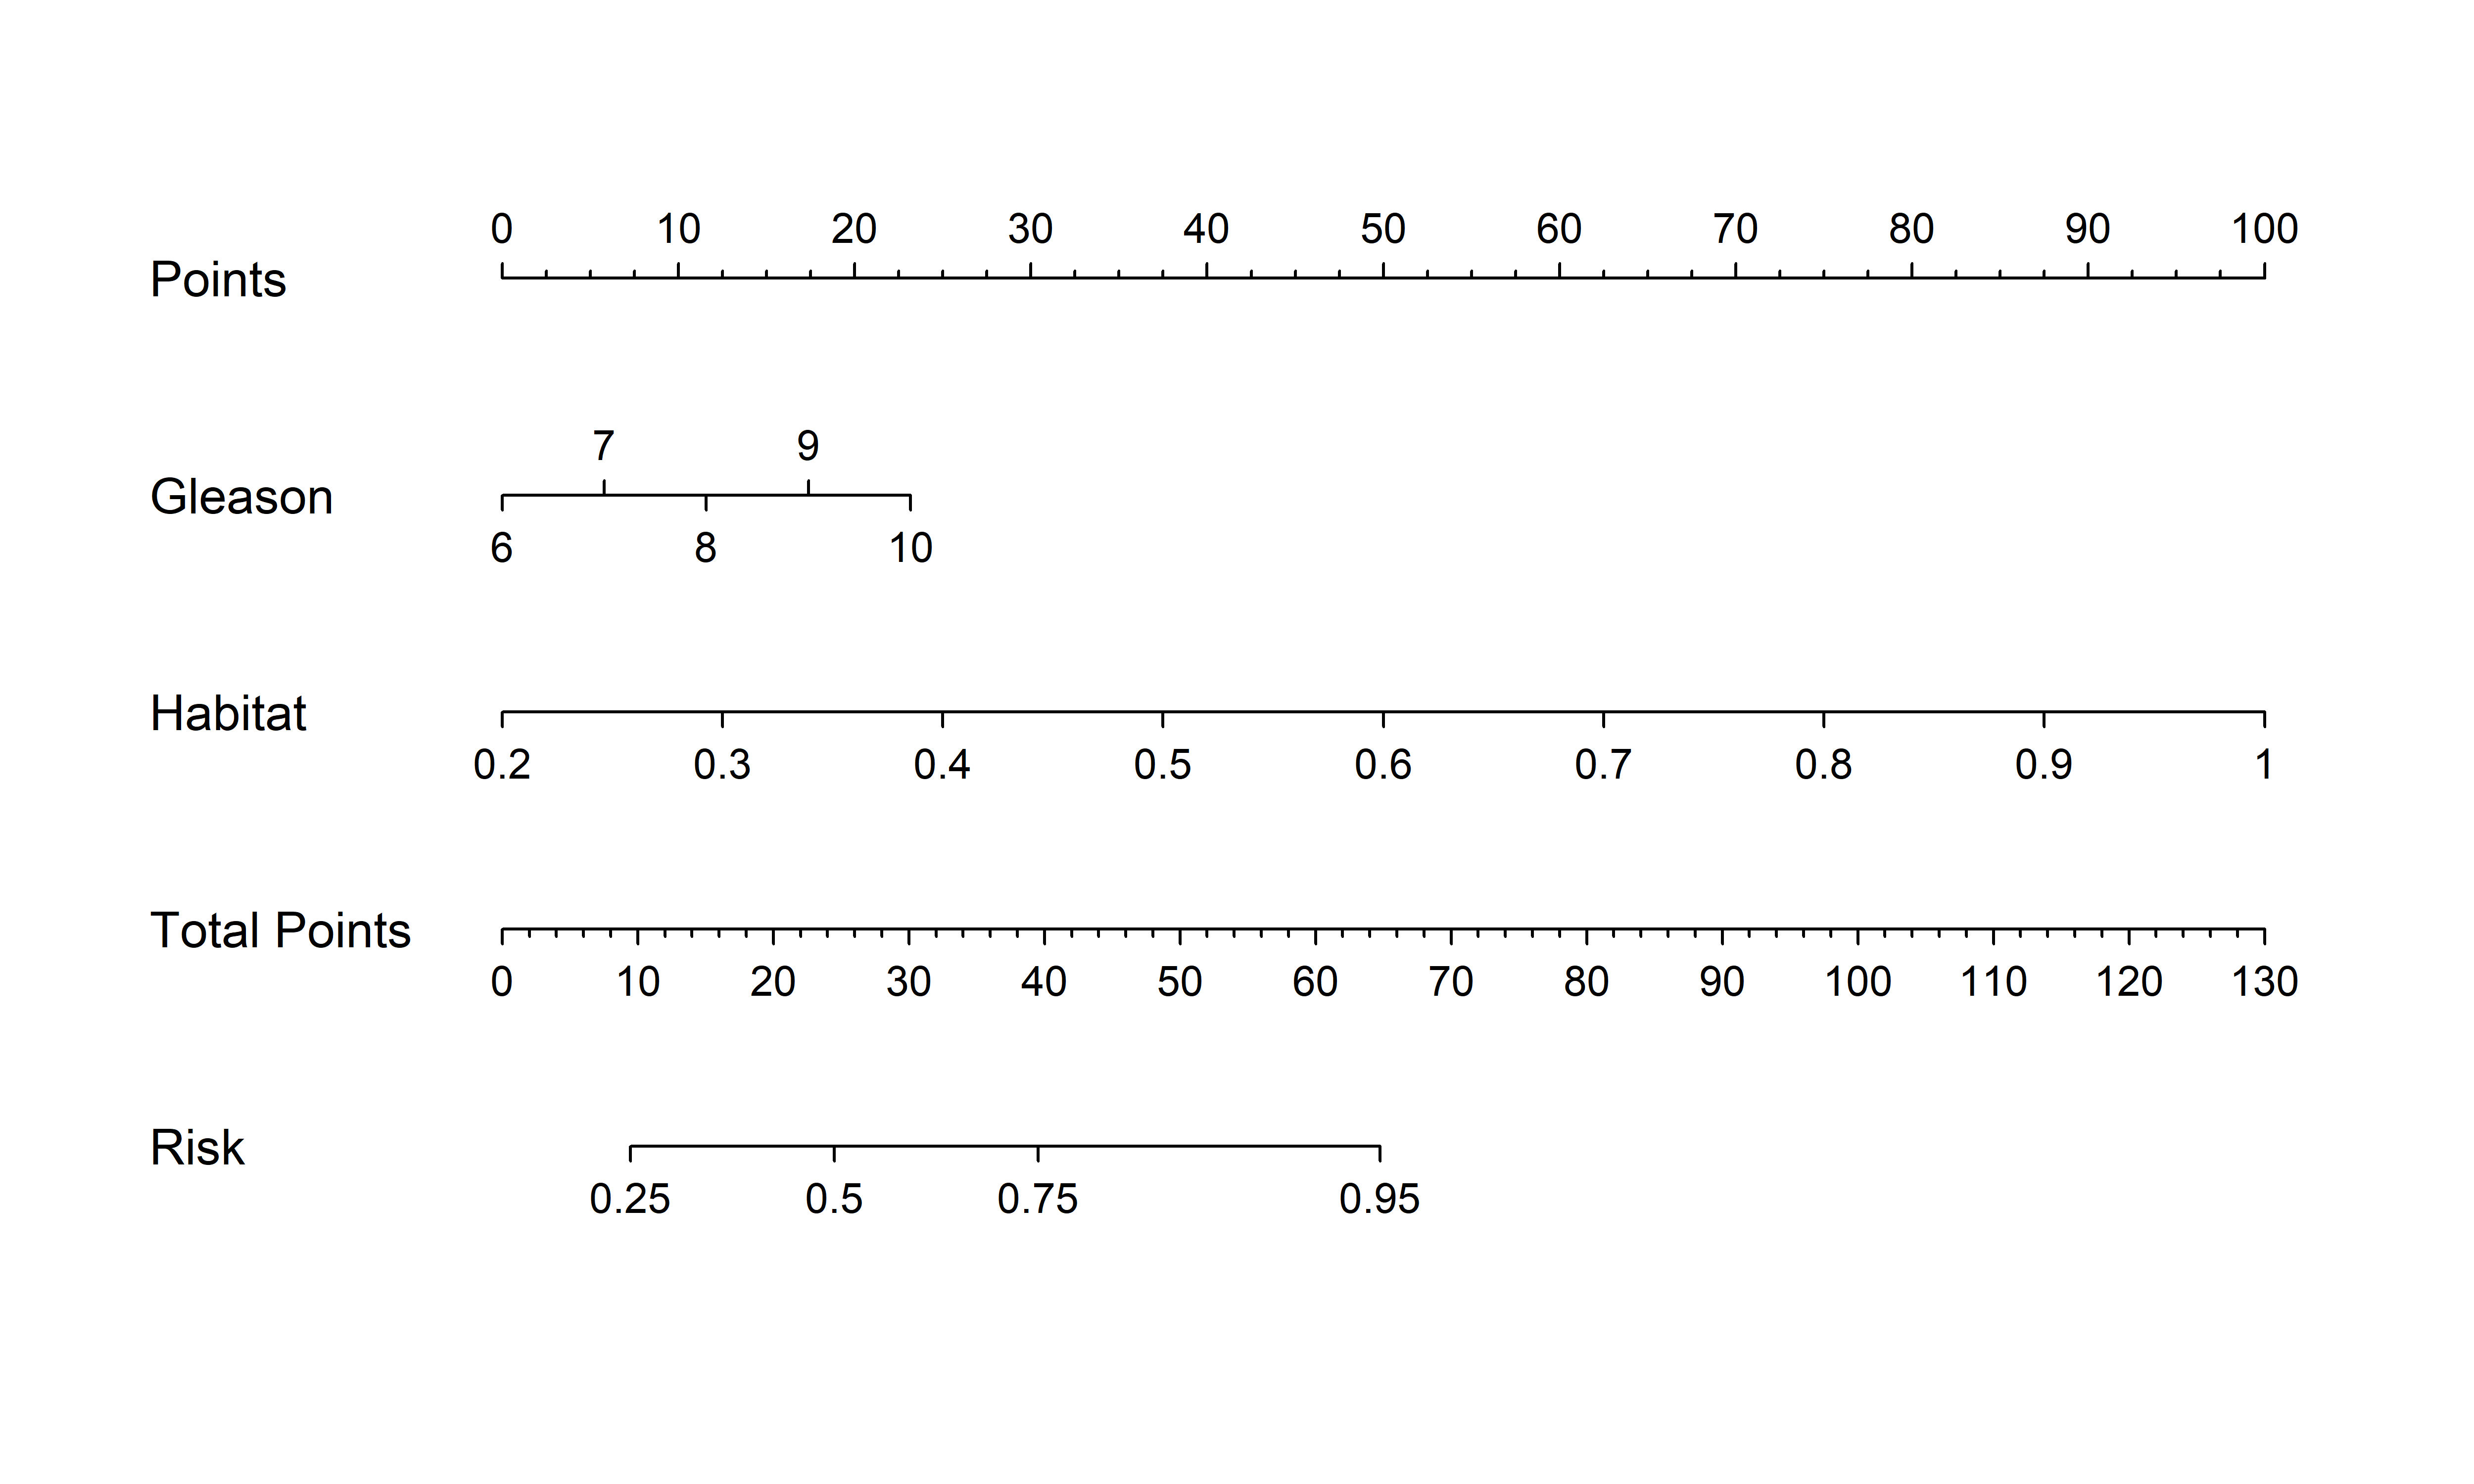

In [27]:
from onekey_algo.custom.components import nomogram
import shutil

ALL_results = ALL_results.round(decimals=2)
ALL_results.columns = [c.replace(' ', '_').replace('.', '') for c in ALL_results.columns]
c = [c.replace(' ', '_').replace('.', '') for c in list(Clinic.columns[1:]) + model_names[-2:-1]]
nomogram.risk_nomogram(ALL_results, result=task, 
                       columns=c, width=5000, height=3000, x_range='0.05,0.25,0.5,0.75,0.95')

# 测试集-Nomogram

[2024-06-11 16:35:49 - metrics.py: 287]	INFO	use_youden index: False


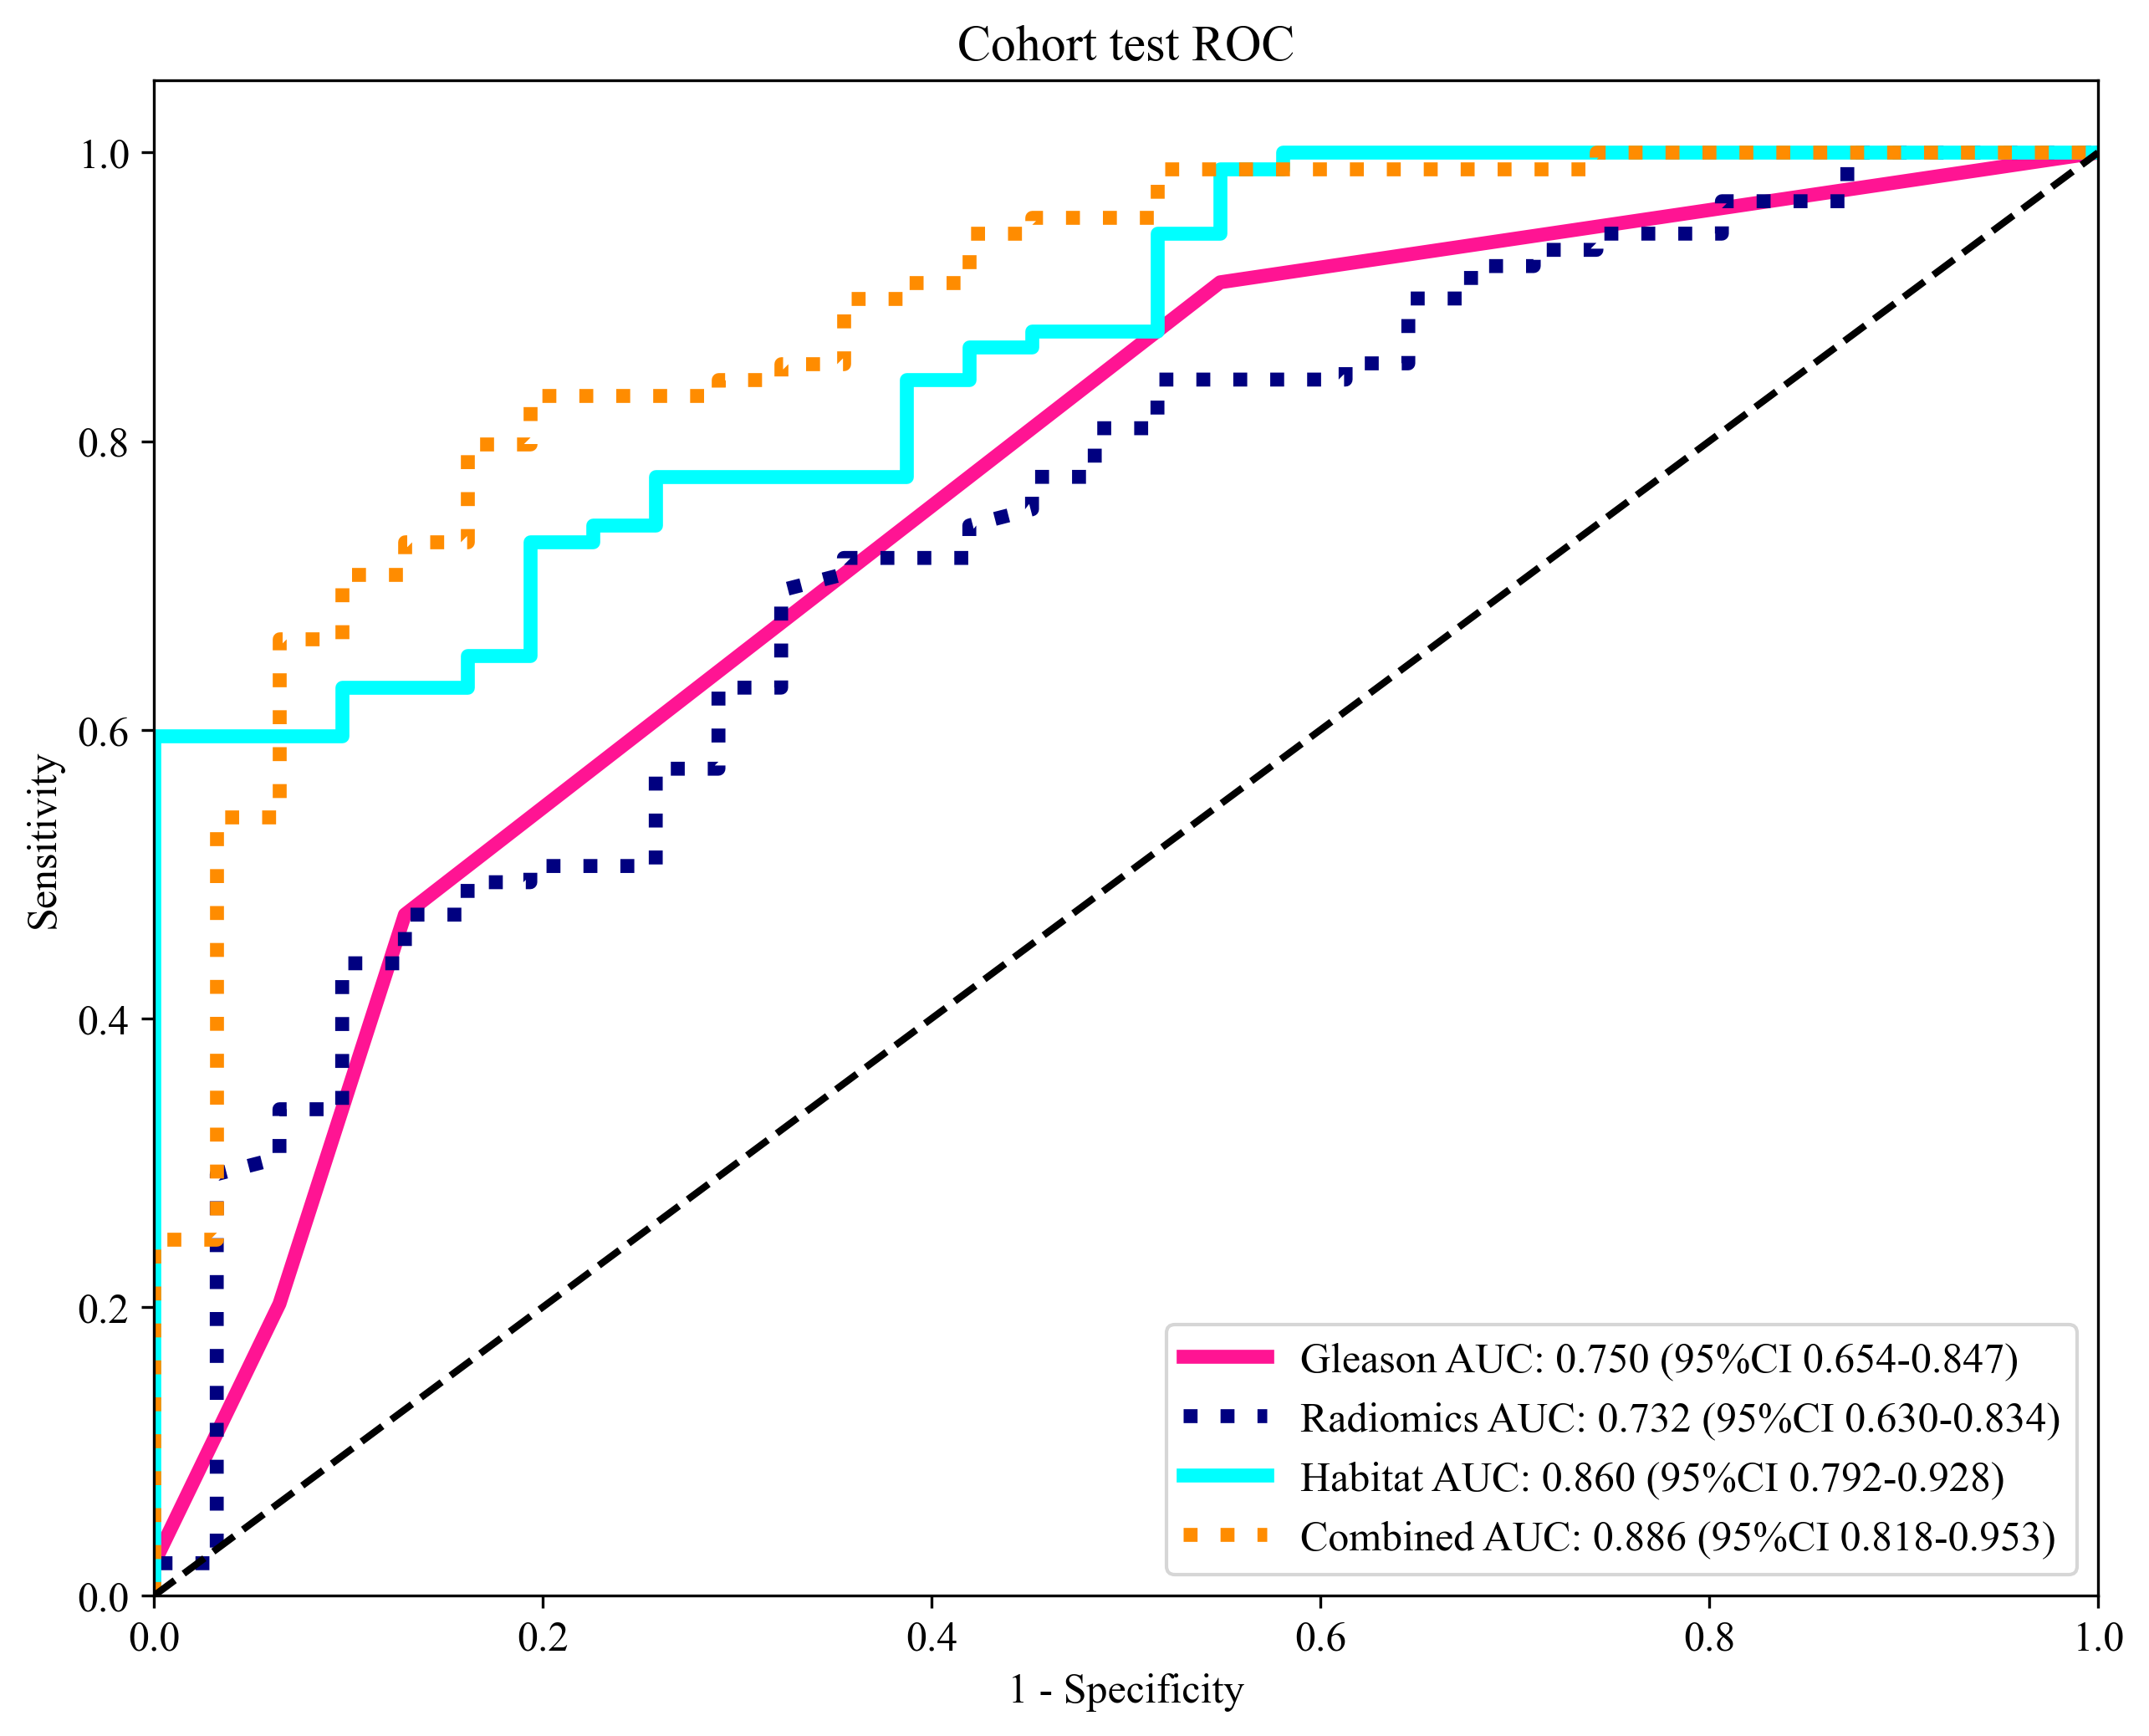

[2024-06-11 16:35:49 - metrics.py: 287]	INFO	use_youden index: False
[2024-06-11 16:35:49 - metrics.py: 287]	INFO	use_youden index: False
[2024-06-11 16:35:49 - metrics.py: 287]	INFO	use_youden index: False
[2024-06-11 16:35:49 - metrics.py: 287]	INFO	use_youden index: False


,Signature,Accuracy,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Precision,Recall,F1,Threshold,Cohort
0,Gleason,0.771,0.648,0.5757 - 0.7200,1.000,0.000,0.771,0.000,0.771,1.000,0.871,7.000,Train
1,Radiomics,0.732,0.761,0.6952 - 0.8266,0.759,0.641,0.877,0.441,0.877,0.759,0.814,0.495,Train
2,Habitat,0.764,0.882,0.8427 - 0.9214,0.736,0.859,0.946,0.491,0.946,0.736,0.828,0.534,Train
3,Combined,0.825,0.889,0.8509 - 0.9276,0.894,0.594,0.881,0.623,0.881,0.894,0.887,0.825,Train
4,Gleason,0.742,0.750,0.6535 - 0.8467,1.000,0.000,0.742,0.000,0.742,1.000,0.852,7.000,test
5,Radiomics,0.742,0.732,0.6304 - 0.8343,0.843,0.452,0.815,0.500,0.815,0.843,0.829,0.534,test
6,Habitat,0.758,0.860,0.7925 - 0.9277,0.764,0.742,0.895,0.523,0.895,0.764,0.824,0.666,test
7,Combined,0.825,0.886,0.8183 - 0.9533,0.899,0.613,0.870,0.679,0.870,0.899,0.884,0.738,test


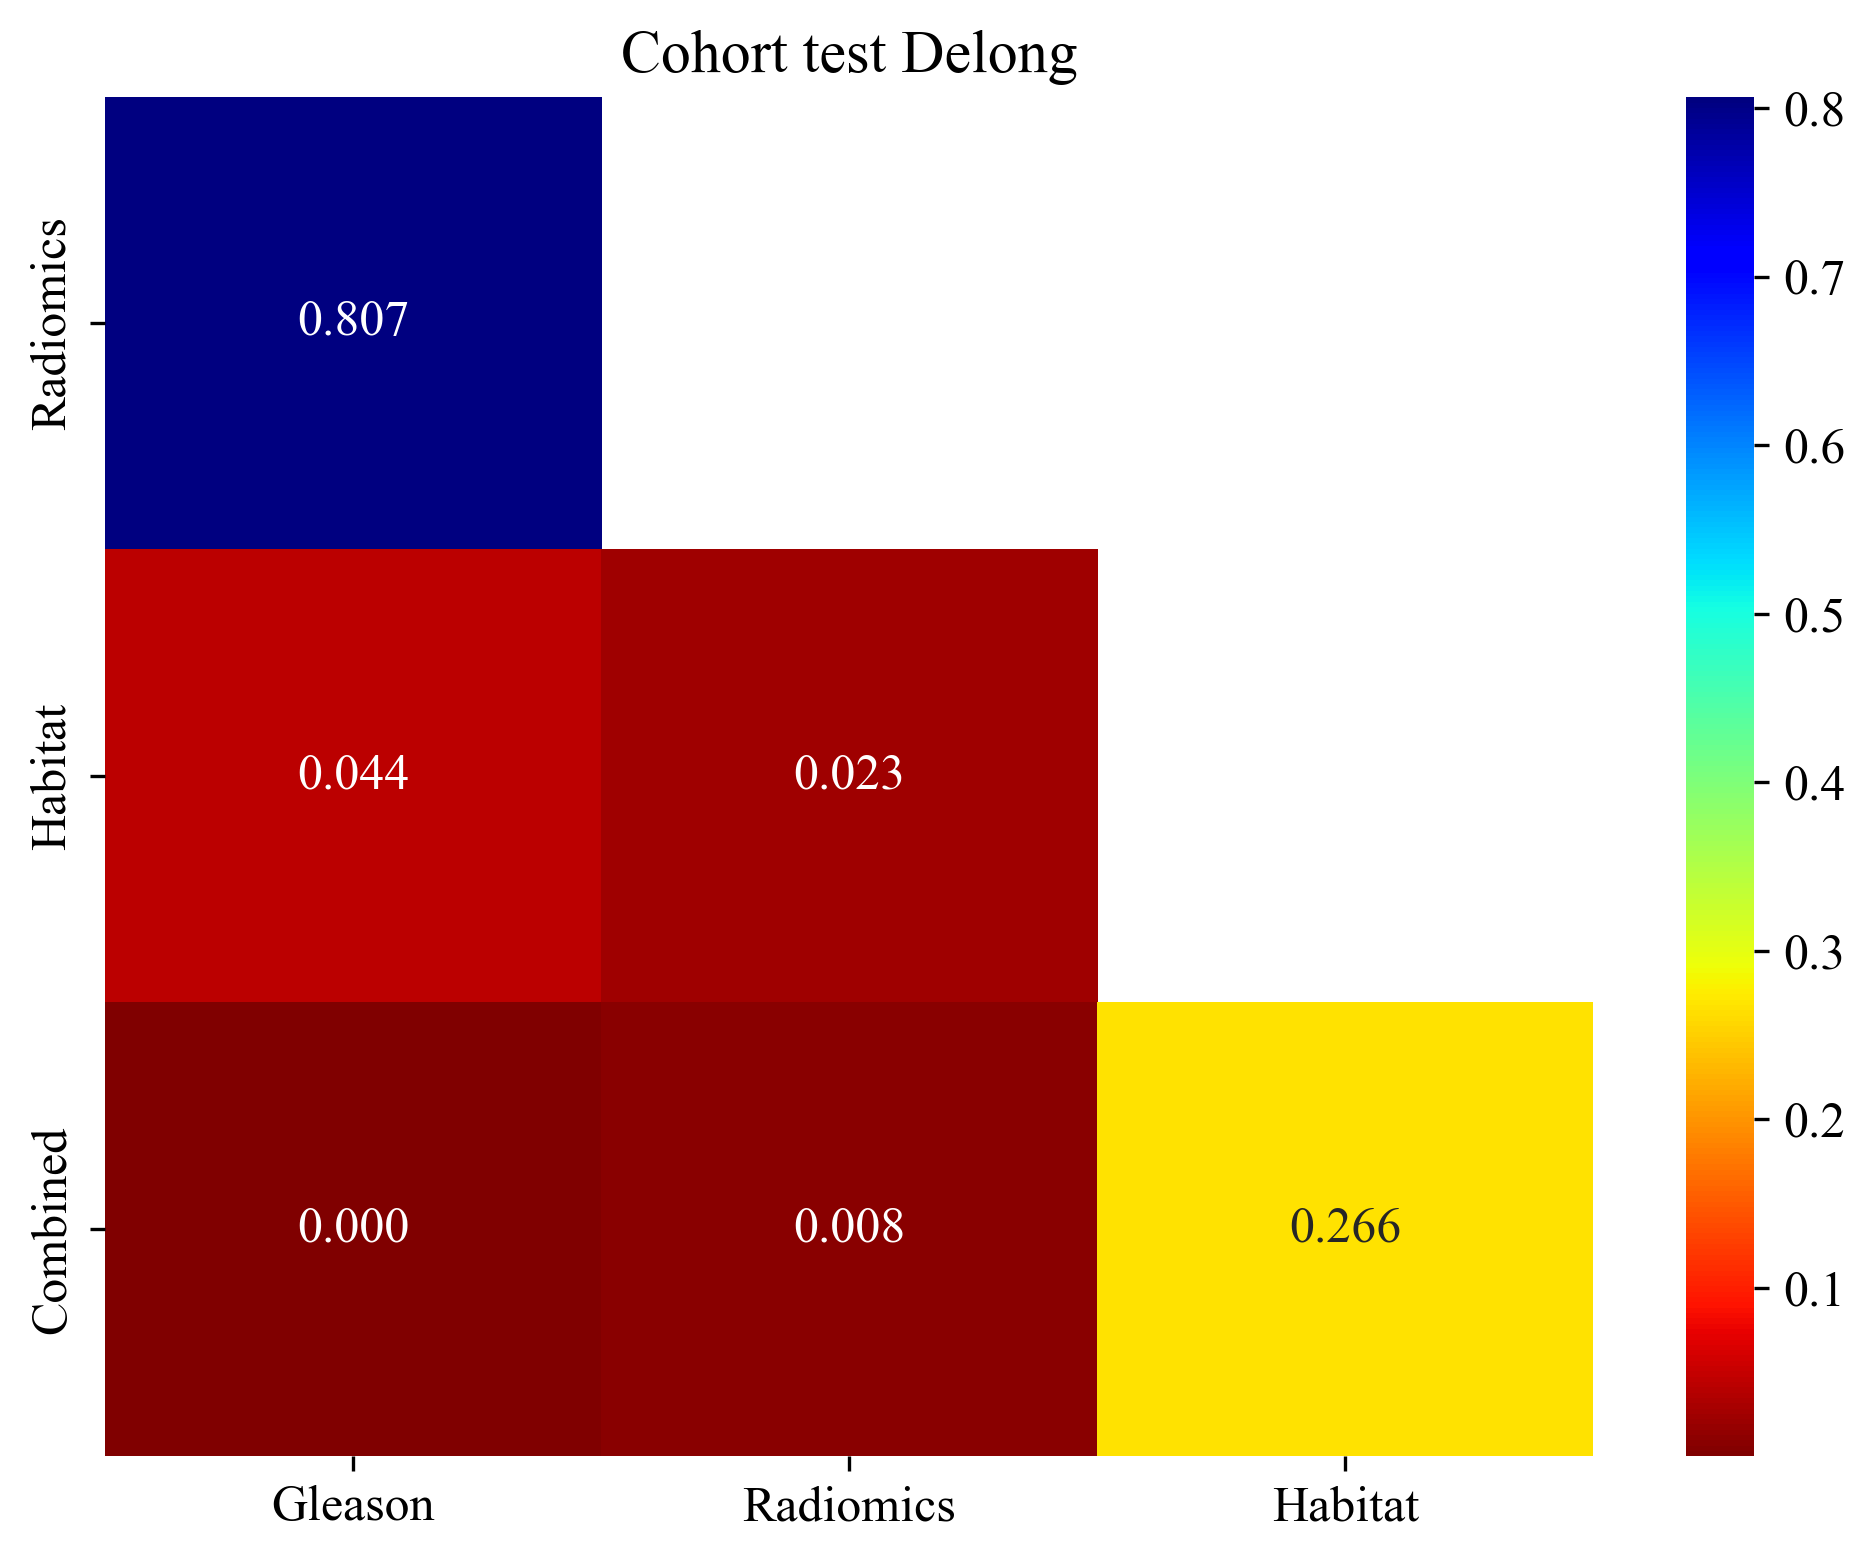

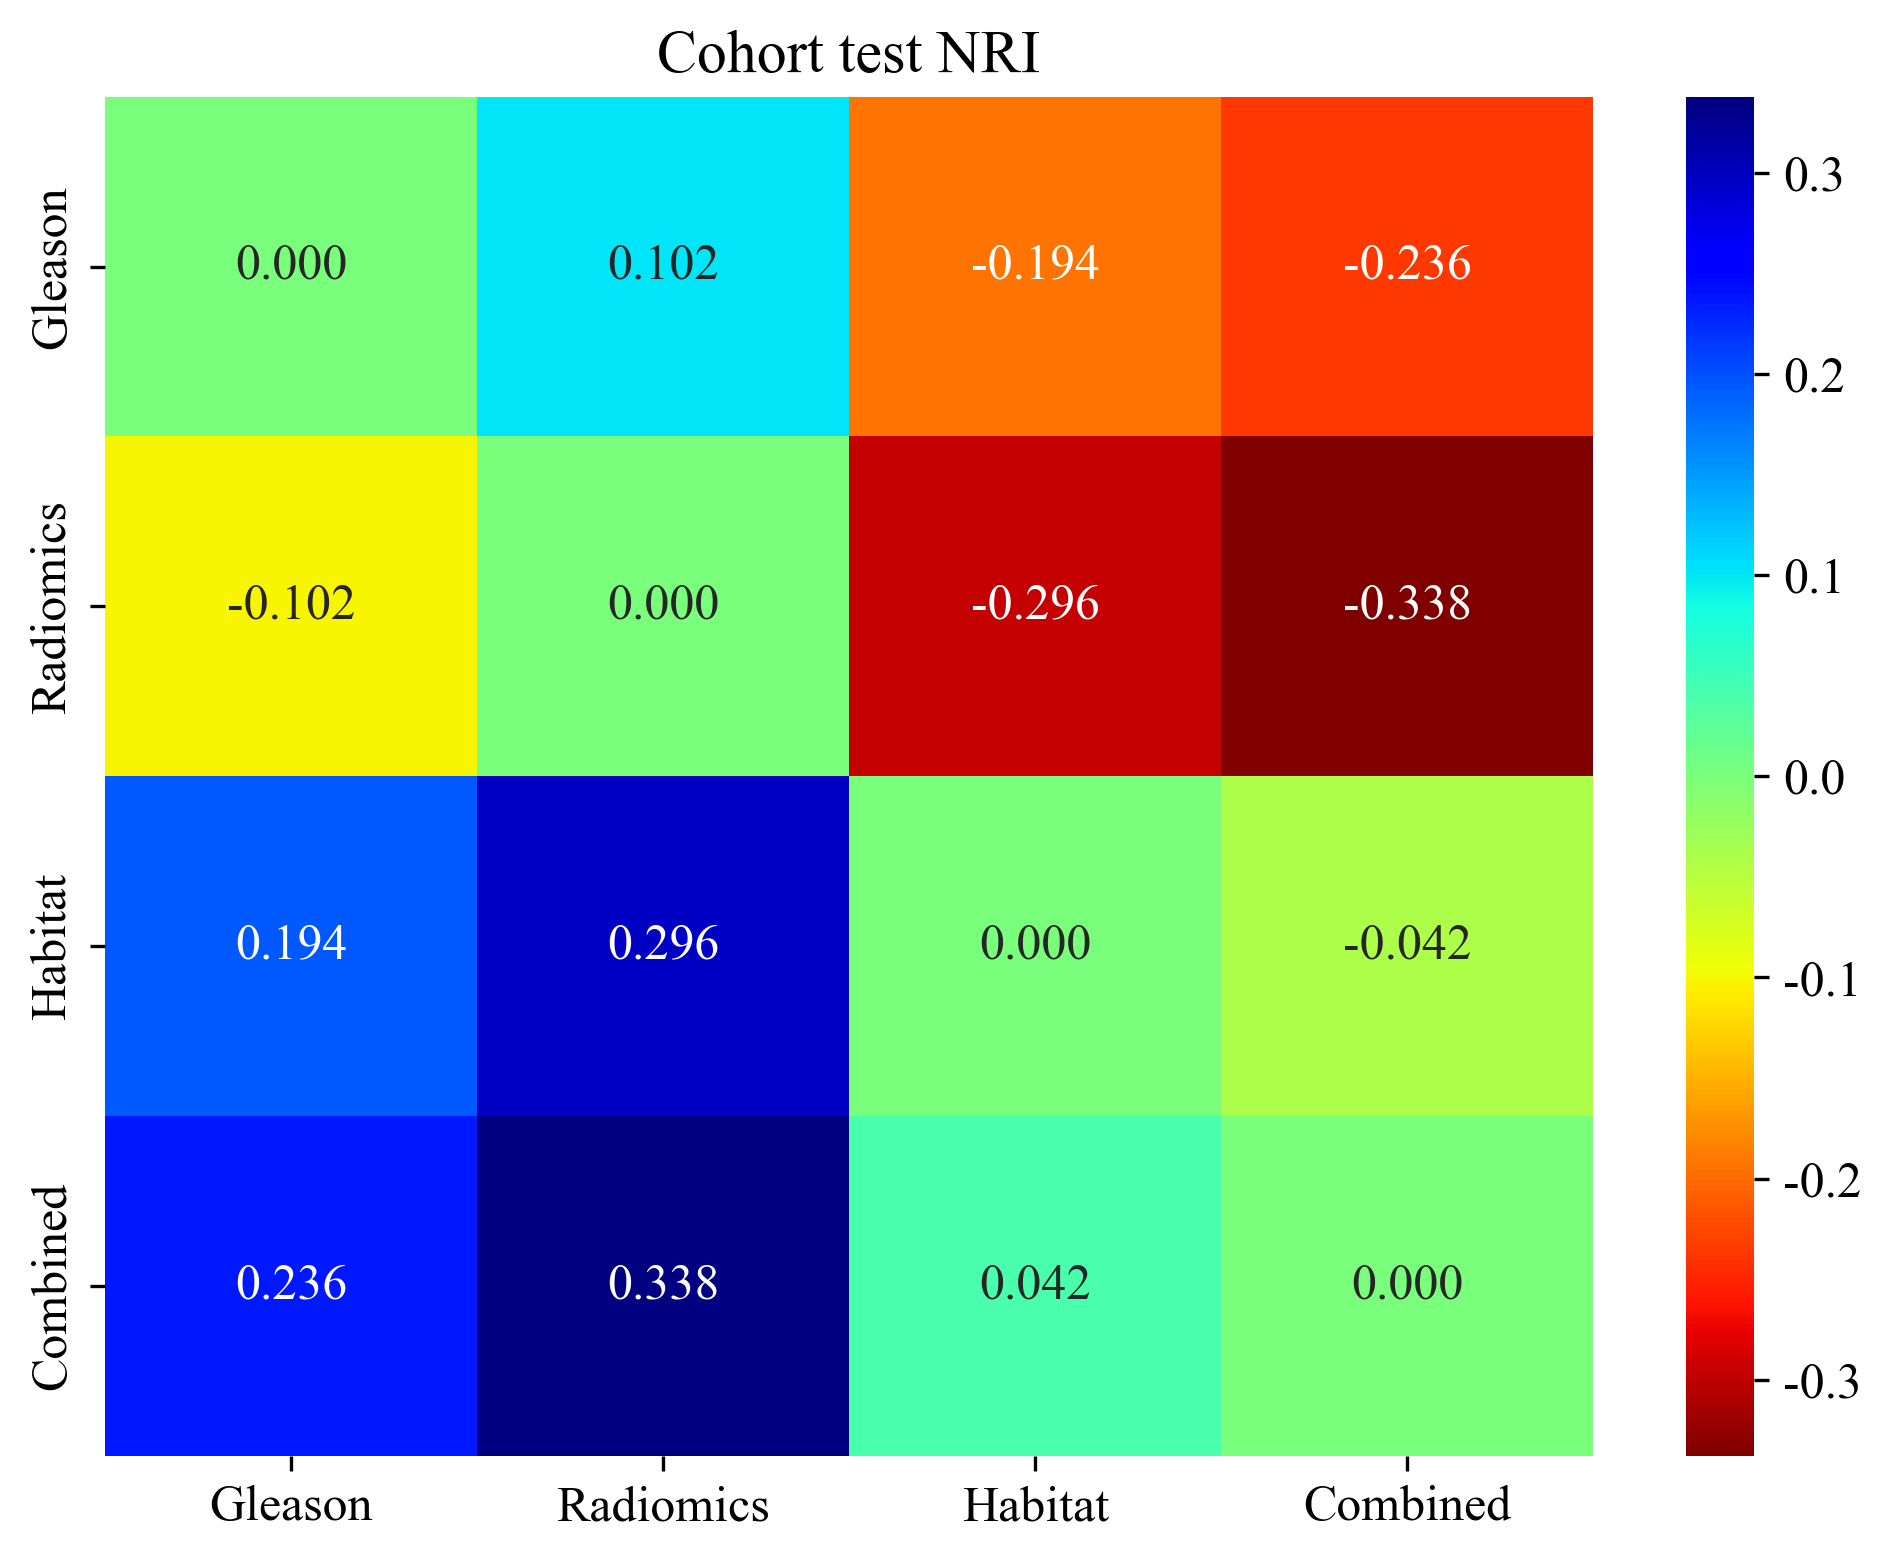

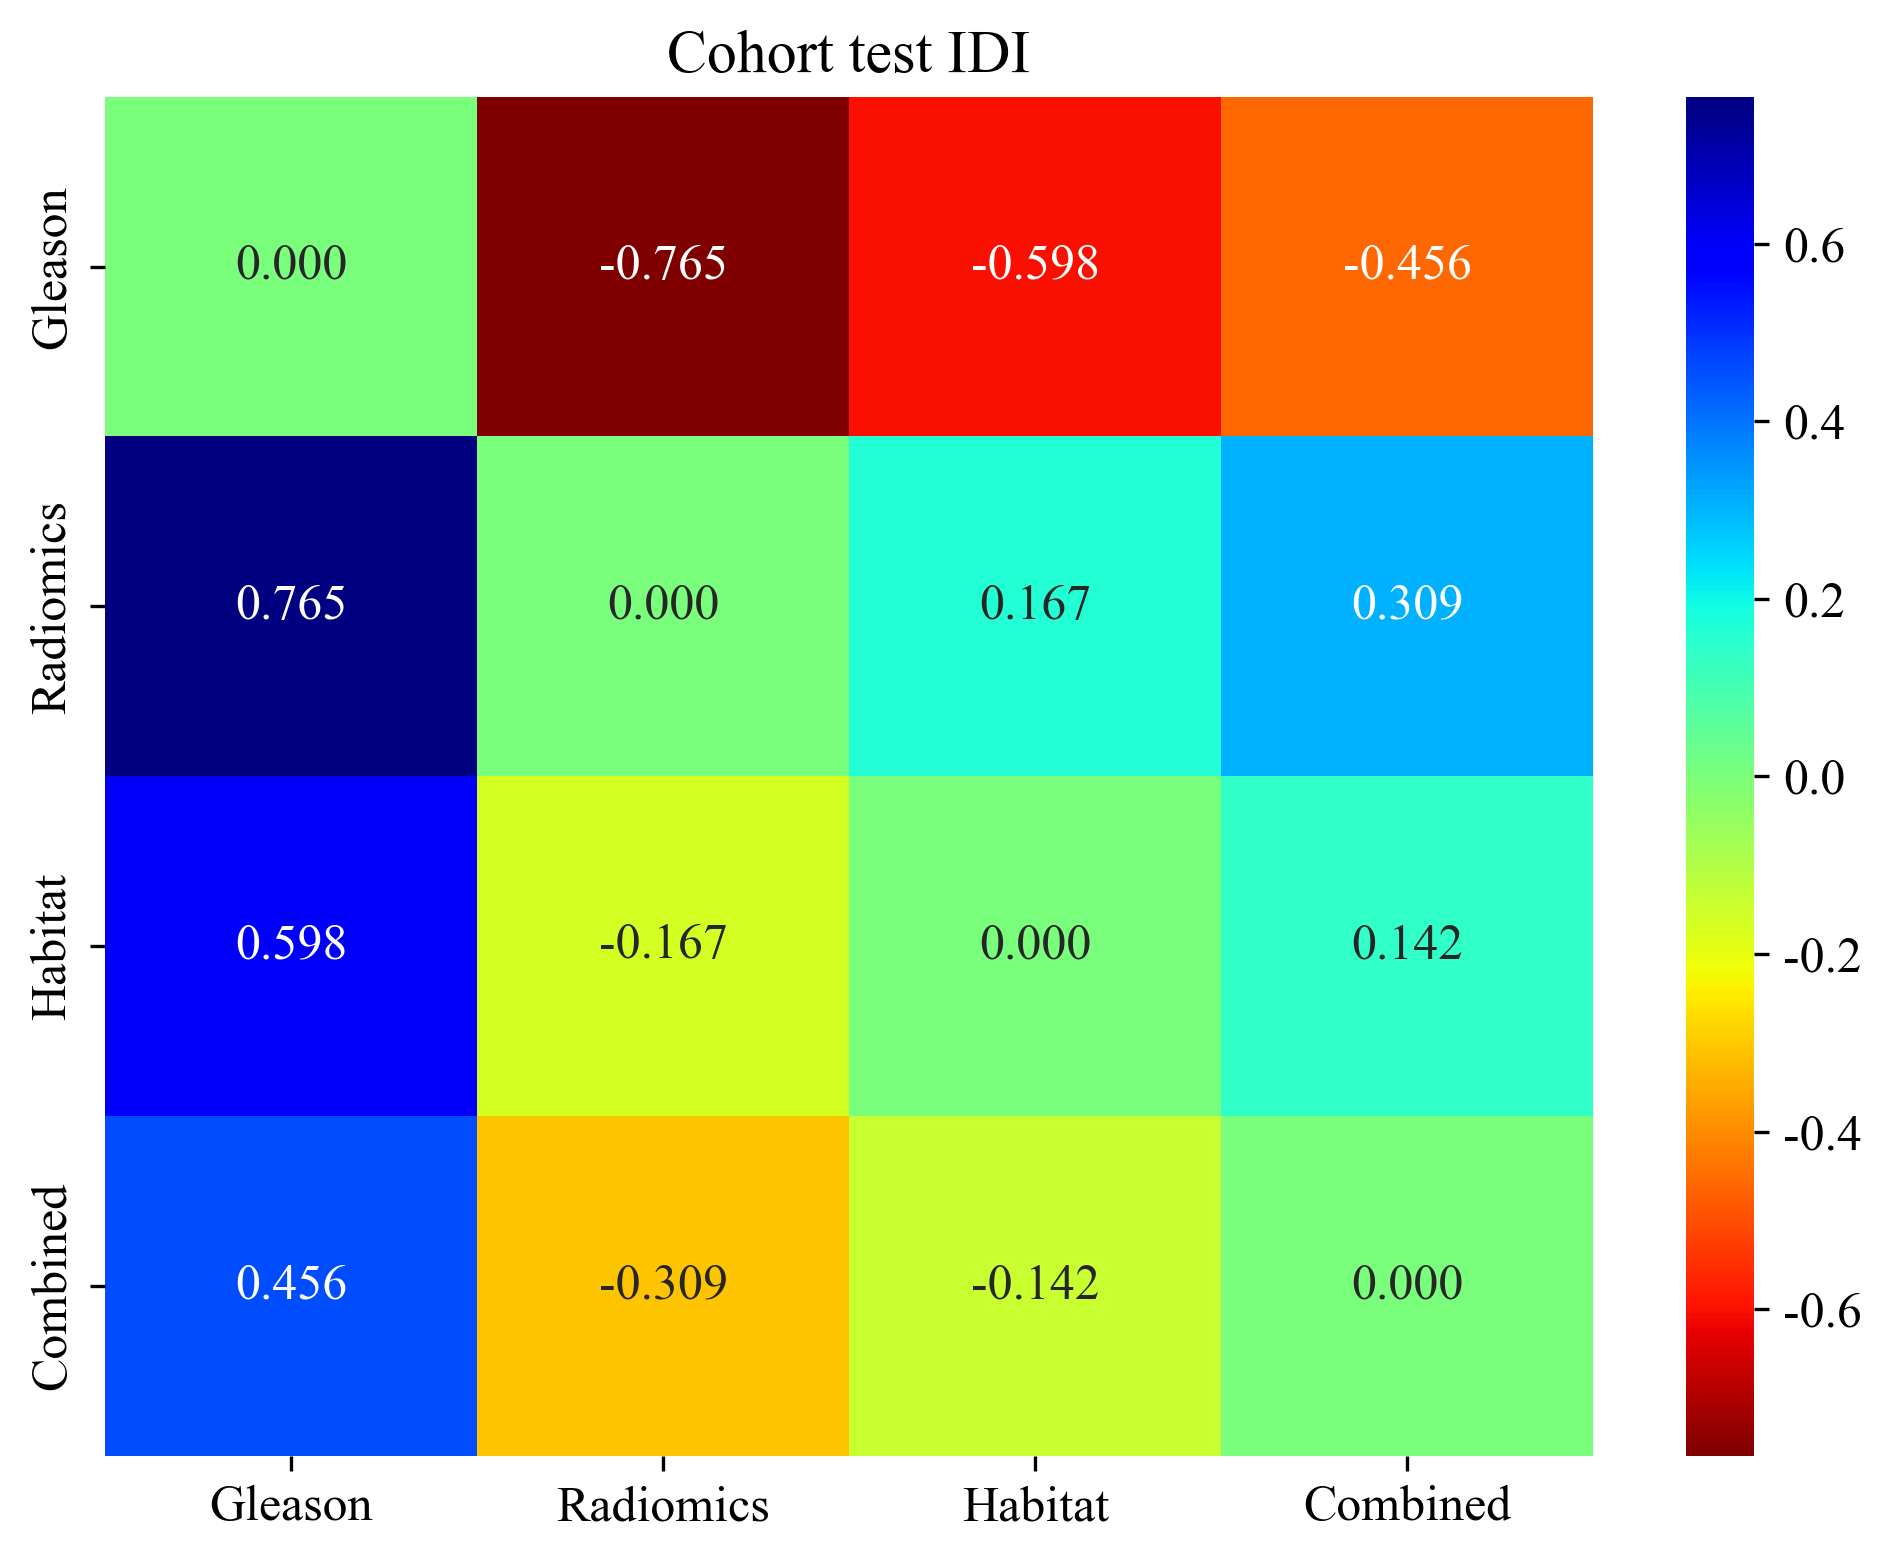

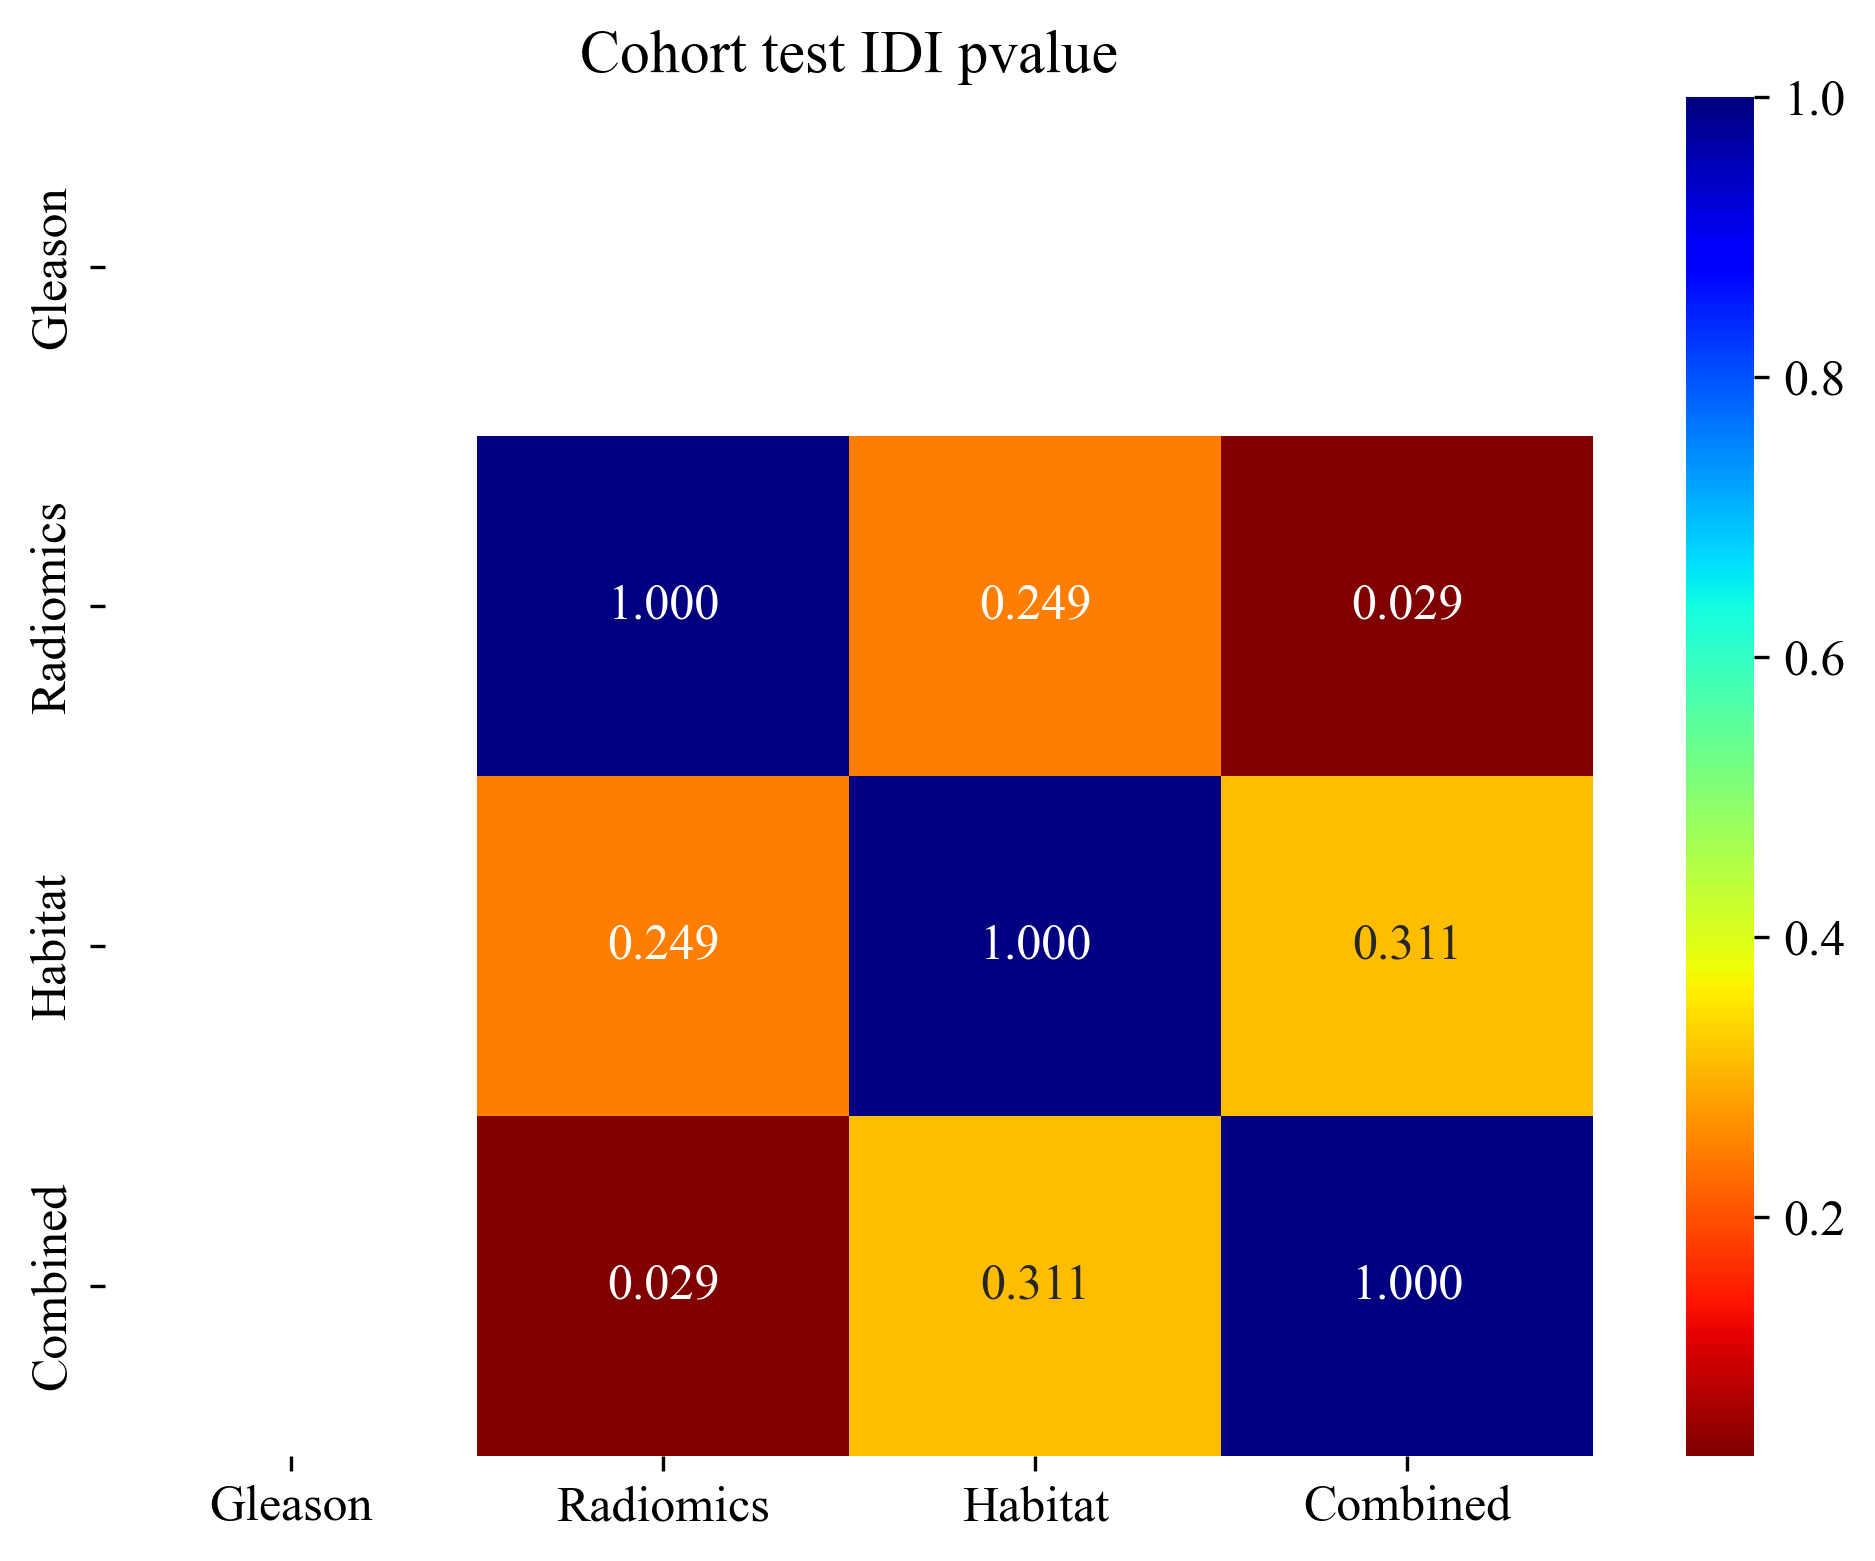

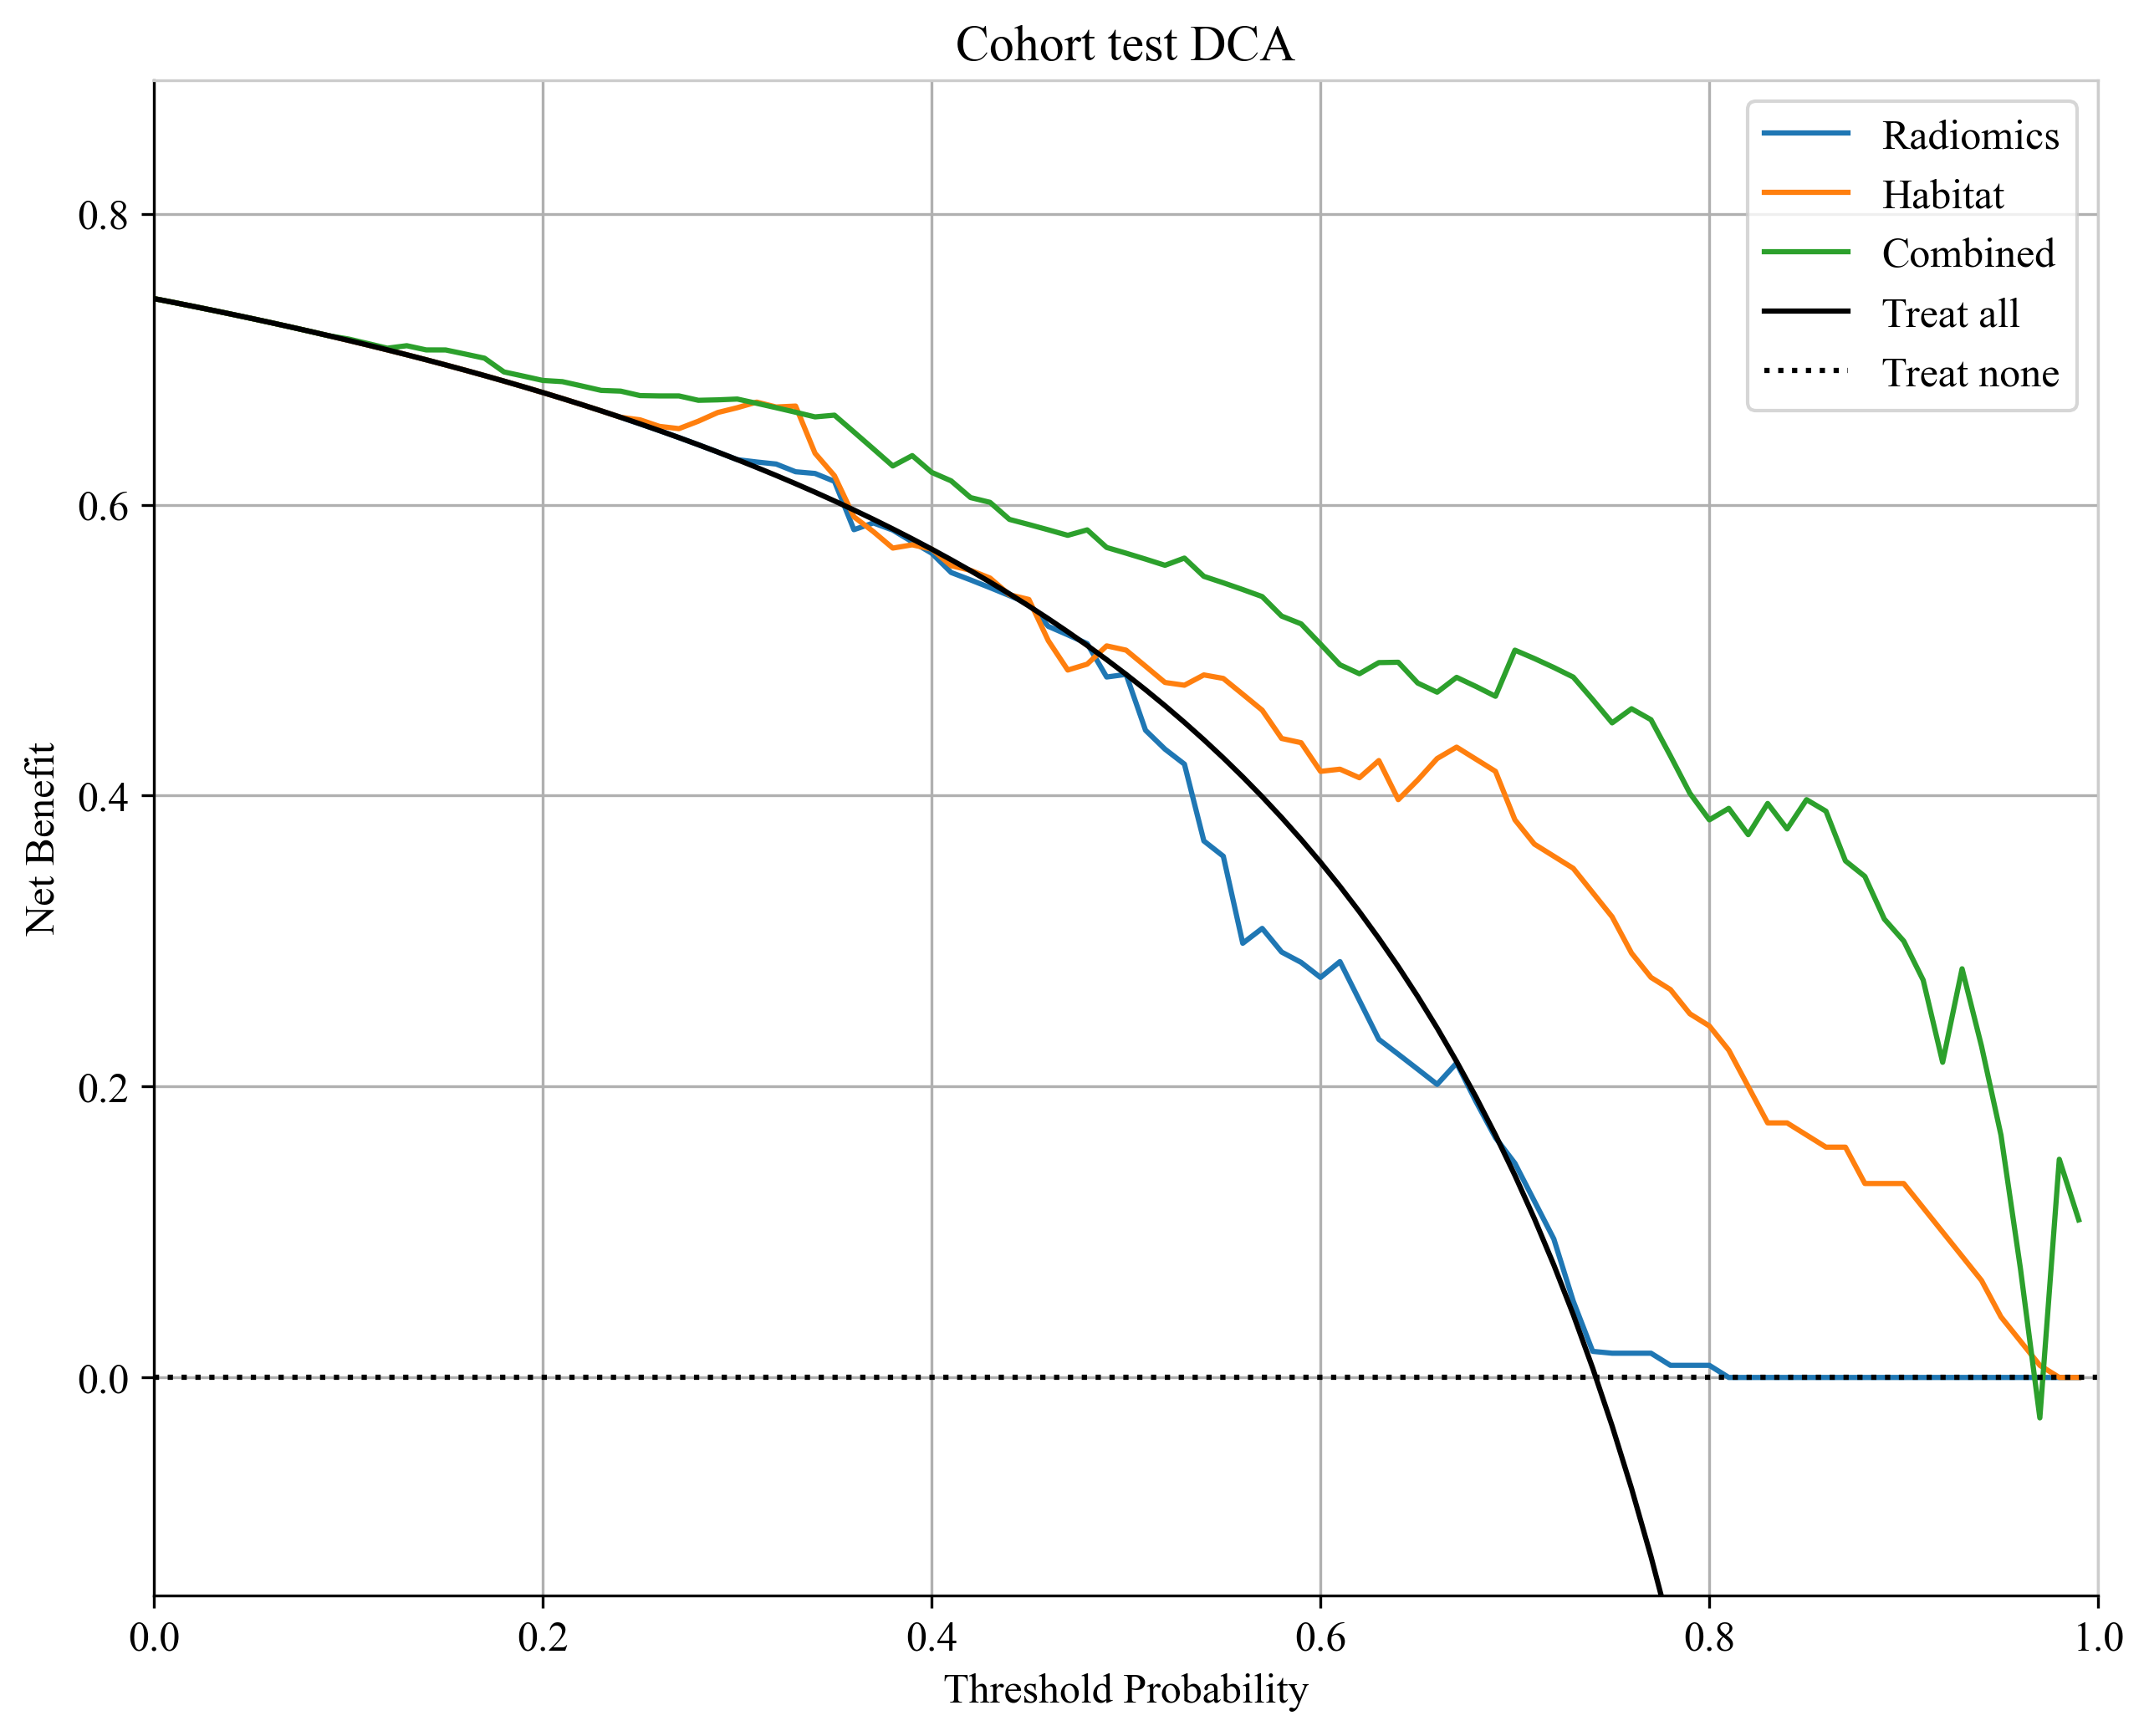

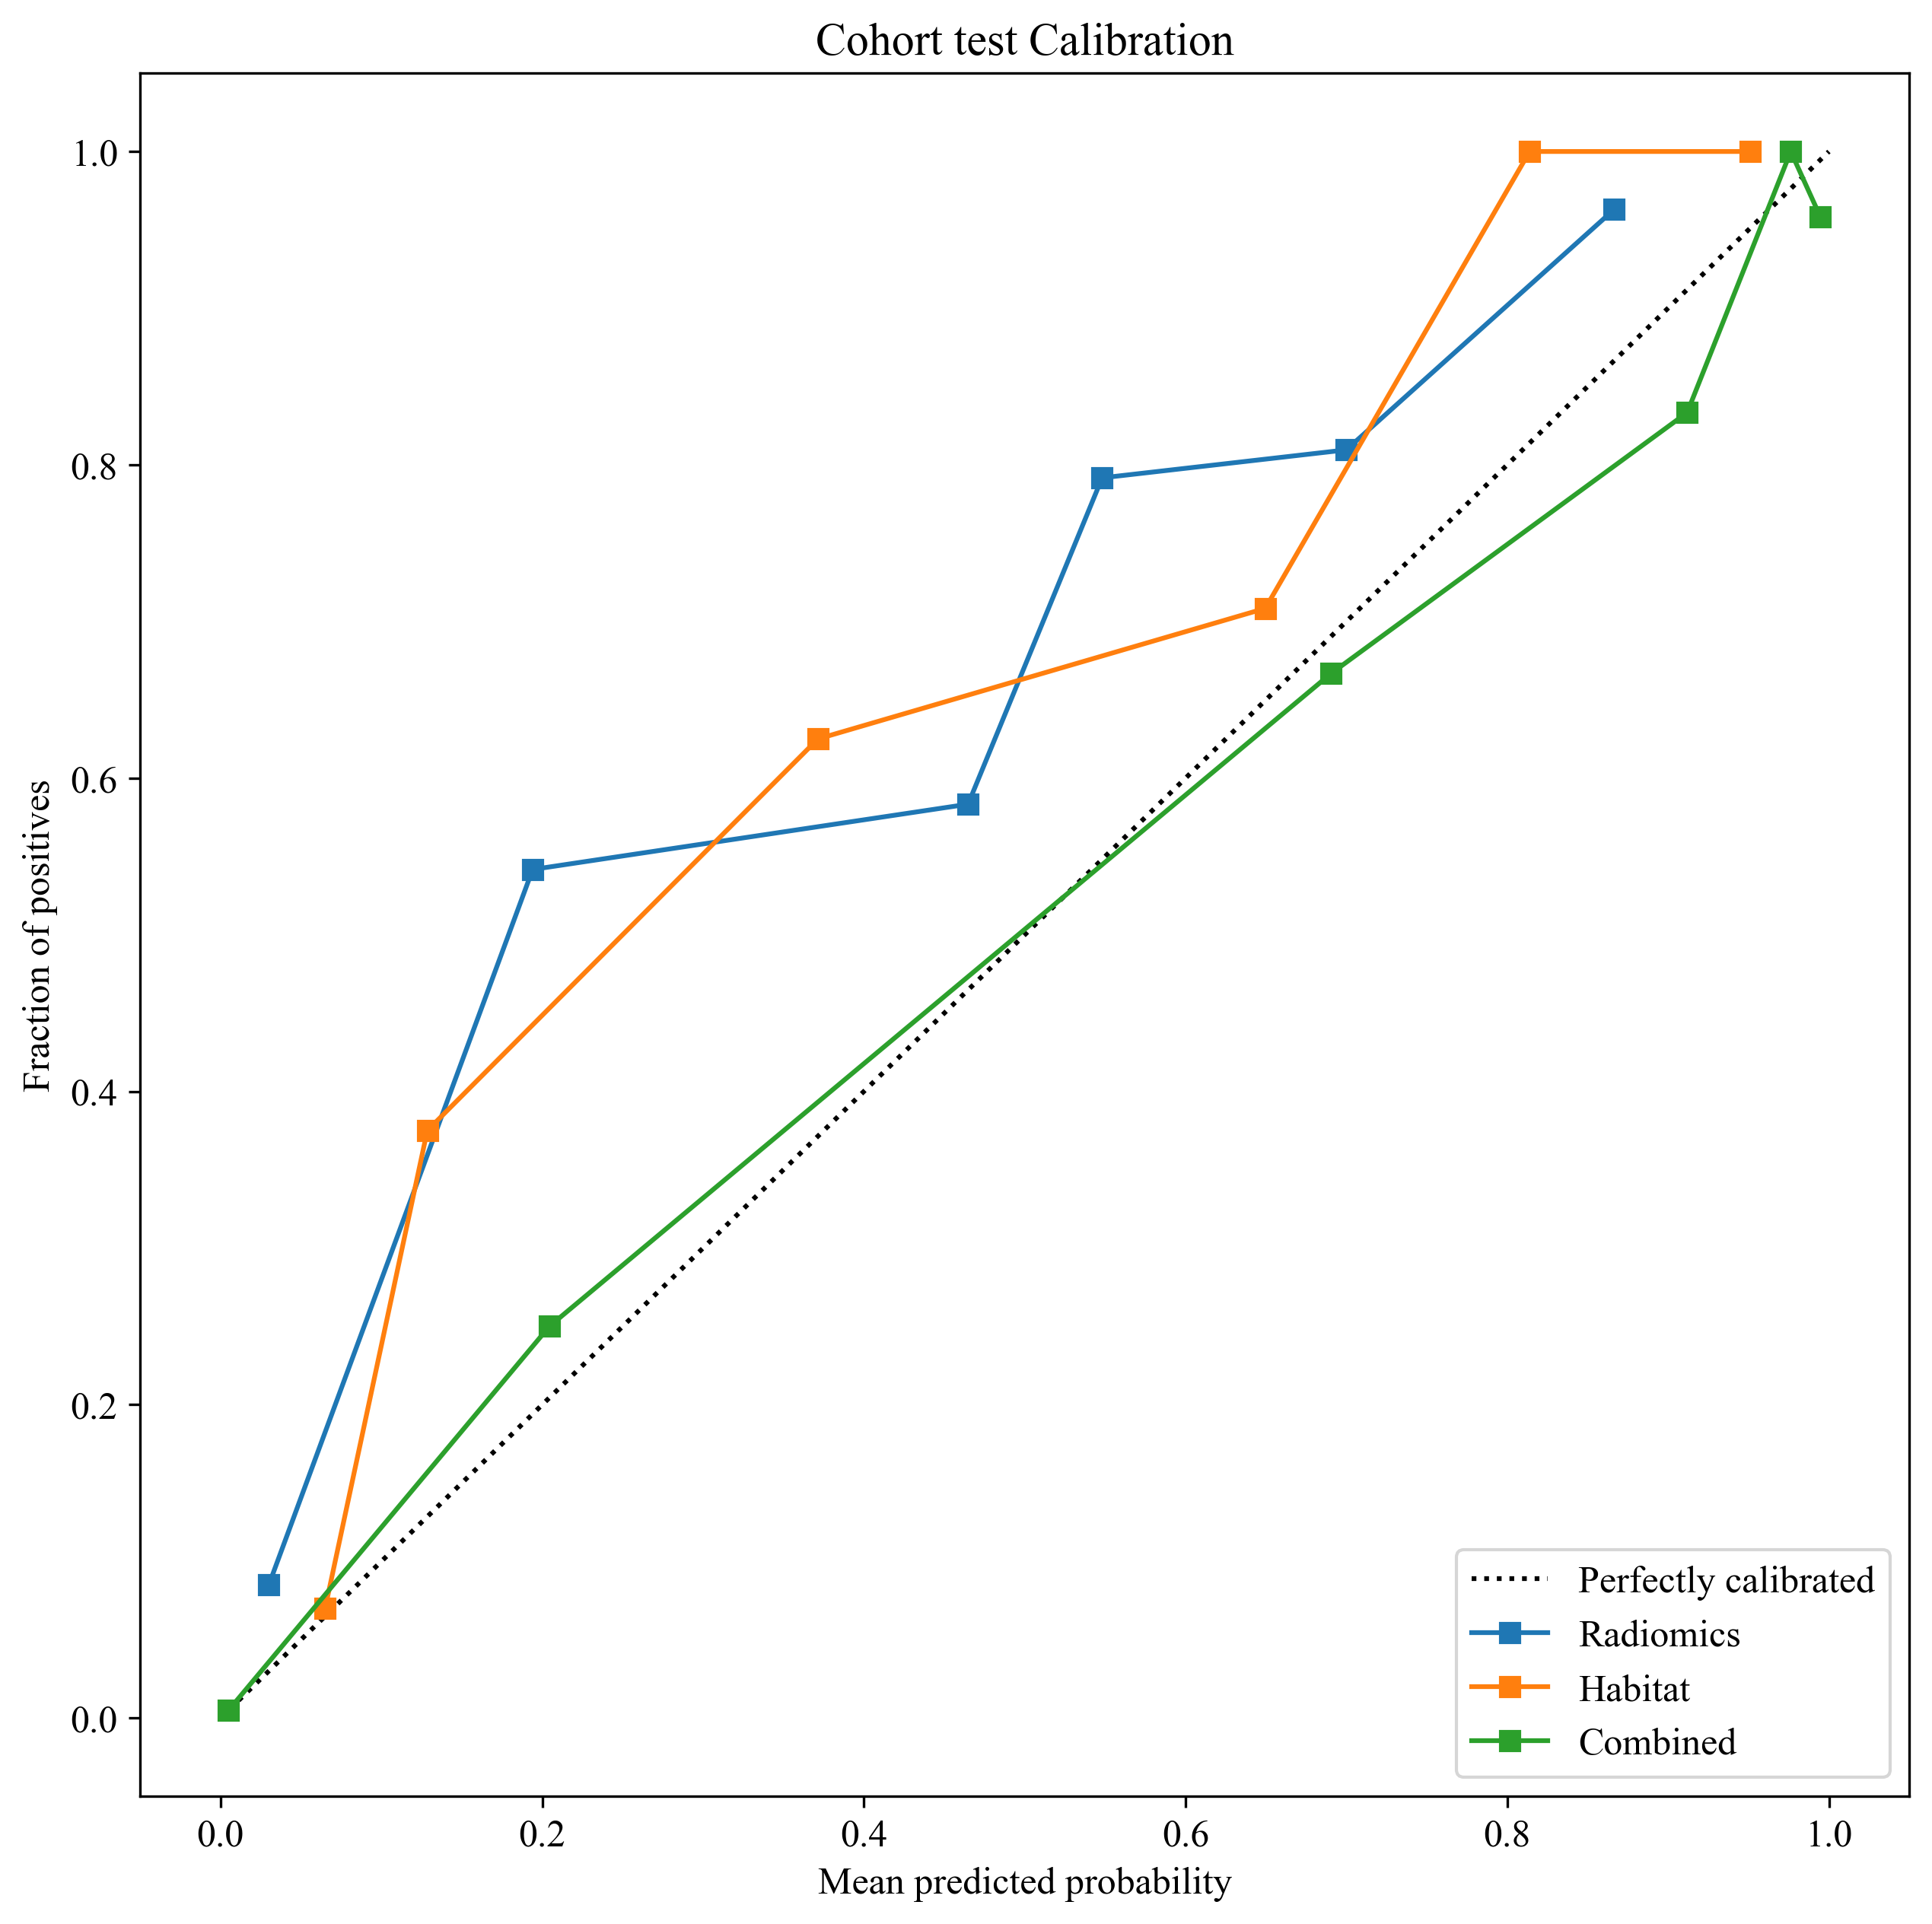

,Gleason,Radiomics,Habitat,Combined,Cohort
0,1.0,1.402e-10,7.766e-07,0.719,Train
1,1.0,2.922e-01,3.355e-02,0.715,Test


In [28]:
import pandas as pd
from onekey_algo.custom.components.comp1 import normalize_df
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from onekey_algo.custom.components import metrics
from onekey_algo.custom.components.delong import delong_roc_test
from onekey_algo.custom.components.comp1 import draw_matrix
from onekey_algo.custom.components.metrics import NRI, IDI
from onekey_algo.custom.components.comp1 import plot_DCA
from onekey_algo.custom.components.comp1 import draw_calibration
from onekey_algo.custom.components import stats

for subset in [ 'test', ]:
#     Clinical_results = pd.merge(pd.read_csv(f'./results/Clinic_{sel_m["Clinical"]}_{subset}.csv', header=0), label_data, on='ID', how='inner')
    P6_results = pd.merge(pd.read_csv(f'./results/Rad_{sel_m["Radiomics"]}_{subset}.csv', header=0), label_data, on='ID', how='inner')
    Habitat_results = pd.merge(pd.read_csv(f'./results/Habitat_{sel_m["Habitat"]}_{subset}.csv', header=0), label_data, on='ID', how='inner')

    ALL_results = merge_results(P6_results, Habitat_results,
                                model_names=model_names[1:-1], label_col=task)
#     ALL_results = normalize_df(ALL_results, not_norm=['ID'], method='minmax')
    Clinic = pd.read_csv('clinic_sel.csv')
    Clinic = Clinic[[c for c in Clinic.columns if c not in ['label', 'group']]]
    ALL_results = pd.merge(ALL_results, Clinic, on='ID', how='inner')
    ALL_results = ALL_results.dropna(axis=1)
#     display(ALL_results)
    
    # 计算Nomogram
    data_x = ALL_results[list(Clinic.columns[1:]) + [model_names[-2]]]
    data_y = ALL_results[task]
    if subset == 'val' or True:
        model = LogisticRegression(random_state=0, penalty='none', max_iter=100)
        model.fit(data_x, data_y)
    # model = SVC(probability=True, random_state=0)
    # data_x = ALL_results[list(Clinic.columns[1:]) + model_names[:-1]]
    results = model.predict_proba(data_x)
    results = pd.DataFrame(results, index=ALL_results['ID'], columns=[f'{task}-0', f'{task}-1']).reset_index()
    results.to_csv(f'./results/Nomo_{subset}.csv', index=False, header=True)
    pd.DataFrame([metrics.analysis_pred_binary(ALL_results[task], results[f'{task}-1'])], 
                      columns=['acc', 'auc', '95%CI', 'Sensitivity', 'Specificity',
                               'PPV', 'NPV', 'Precision', 'Recall', 'F1', 'Threshold'])
    
    # 绘制整体的ROC曲线
    pred_column = [f'{task}-0', f'{task}-1']
    Nomo_results = pd.read_csv(f'./results/Nomo_{subset}.csv', header=0)
    Nomo_results.columns = ['ID', 'label-9', model_names[-1]]
    ALL_results = pd.merge(ALL_results, Nomo_results, on='ID', how='inner')
    gt = [np.array(ALL_results[task]) for _ in model_names]
    pred_train = [np.array(ALL_results[d]) for d in model_names]
    okcomp.comp1.draw_roc(gt, pred_train, labels=model_names, title=f'Cohort {subset} ROC')
    plt.savefig(f'img/{subset}_auc.svg')
    plt.show()
    
    # 汇总所有的Metric
    for mname, y, score in zip(model_names, gt, pred_train):
        # 计算验证集指标
        acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y, score, use_youden=True)
        ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
        metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, subset))
    metric_ = pd.DataFrame(metric, index=None, columns=['Signature', 'Accuracy', 'AUC', '95% CI',
                                                       'Sensitivity', 'Specificity', 
                                                       'PPV', 'NPV', 'Precision', 'Recall', 'F1',
                                                       'Threshold', 'Cohort'])

    display(metric_)
    
    # 绘制Delong
    delong = []
    delong_columns = []
    this_delong = []
    plt.figure(figsize=(8, 6))
    cm = np.zeros((len(model_names), len(model_names)))
    for i, mni in enumerate(model_names):
        for j, mnj in enumerate(model_names):
            if i <= j:
                cm[i][j] = np.nan
            else:
                cm[i][j] = delong_roc_test(ALL_results[task], ALL_results[mni], ALL_results[mnj])[0][0]
    cm = pd.DataFrame(cm[1:, :-1], index=model_names[1:], columns=model_names[:-1])
    draw_matrix(cm, annot=True, cmap='jet_r', cbar=True)
    plt.title(f'Cohort {subset} Delong')
    plt.savefig(f'img/all_delong_each_cohort_{subset}.svg', bbox_inches = 'tight')
    plt.show()
    
    # NRI
    delong = []
    delong_columns = []
    this_delong = []
    plt.figure(figsize=(8, 6))
    cm = np.zeros((len(model_names), len(model_names)))
    for i, mni in enumerate(model_names):
        for j, mnj in enumerate(model_names):
            cm[i][j] = NRI(ALL_results[mni] > youden[mni], ALL_results[mnj] > youden[mnj], ALL_results[task])
    cm = pd.DataFrame(cm, index=model_names, columns=model_names)
    draw_matrix(cm, annot=True, cmap='jet_r', cbar=True)
    plt.title(f'Cohort {subset} NRI')
    plt.savefig(f'img/all_NRI_each_cohort_{subset}.svg', bbox_inches = 'tight')
    plt.show()
    
    # IDI
    delong = []
    delong_columns = []
    this_delong = []
    cm = np.zeros((len(model_names), len(model_names)))
    p = np.zeros((len(model_names), len(model_names)))
    for i, mni in enumerate(model_names):
        for j, mnj in enumerate(model_names):
            cm[i][j], p[i][j] = IDI(ALL_results[mni], ALL_results[mnj], ALL_results[task], with_p=True)

    for d, n in zip([cm, p], ['IDI', 'IDI pvalue']):
        plt.figure(figsize=(8, 6))
        d = pd.DataFrame(d, index=model_names, columns=model_names)
        draw_matrix(d, annot=True, cmap='jet_r', cbar=True)
        plt.title(f'Cohort {subset} {n}')
        plt.savefig(f'img/all_{n}_each_cohort_{subset}.svg', bbox_inches = 'tight')
        plt.show()
        
    # DCA
    plot_DCA([ALL_results[model_name] for model_name in model_names[1:]], 
             ALL_results[task], title=f'Cohort {subset} DCA', labels=model_names[1:], y_min=-0.15, remap=False)
    plt.savefig(f'img/{subset}_dca.svg')
    plt.show()
    
    # Calibration
    draw_calibration(pred_scores=pred_train[1:], n_bins=5, remap=True, add_0=True,
                     y_test=gt[1:], model_names=model_names[1:])
    plt.title(f'Cohort {subset} Calibration')
    plt.savefig(f'img/{subset}_cali.svg')
    plt.show()
    
    # HLTest
    hosmer.append([stats.hosmer_lemeshow_test(y_true, y_pred, bins=20, remap=True) 
                  for fn, y_true, y_pred in zip(model_names, gt, pred_train)])
pd.concat([pd.DataFrame(hosmer, columns=model_names), pd.DataFrame(['Train', 'Test'], columns=['Cohort'])], axis=1)